 #  <center>Pharmaceutical Sales prediction across multiple stores</center>
 **Rossmann is Germany's second-largest drug store chain, with over 3,600 stores in Europe.**

**    Id** - an Id that represents a (Store, Date) duple within the test set
    
**    Store** - a unique Id for each store
    
**    Sales** - the turnover for any given day (this is what i am predicting)
    
**    Customers** - the number of customers on a given day
    
**    Open** - an indicator for whether the store was open: 0 = closed, 1 = open
    
**    StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.
    Note    that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, 
    c =   Christmas, 0 = None
    
**    SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
    
**    StoreType** - differentiates between 4 different store models: a, b, c, d
    
**    Assortment** - describes an assortment level: a = basic, b = extra, c = extended
    
**    CompetitionDistance** - distance in meters to the nearest competitor store
    
**    CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
    
**    Promo** - indicates whether a store is running a promo on that day
    
**    Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating,
     1 = store is participating
     
**    Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
    
**    PromoInterval**-describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.
    E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store 

## Import libraries

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Handle table-like data and matrices
import numpy as np
import pandas as pd
import math 


# Modelling Algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error


# Modelling Helpers
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns


# Configure visualisations
%matplotlib inline
mpl.style.use( 'fivethirtyeight' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 18 , 8

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

## Read in the Dataset

In [3]:
# import file 'store.csv'
print('Reading Data in ......')
store_data = pd.read_csv('data/store.csv')
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
print('Data Loaded and Ready for Analysis!')

Reading Data in ......
Data Loaded and Ready for Analysis!


**Check the first 5 rows of the data**

In [4]:
print('Store Data')
display(store_data.head())
print('Test Data')
display(test_data.head())
print('Train Data')
display(train_data.head())

Store Data


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Test Data


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Train Data


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Since Store as been provided as additional dataset, it will make sense to explore the train and test data with the store data.  SO i will merge them. 

 **Merge Train Data with Store data using the Store as a primary key between the 2 dataset**

In [5]:
# merge train data with store data how='outer' to join all data values.
# This may result into missing data in some columns, i will deal with that later
train_store_df = pd.merge(store_data, train_data, on='Store', how='outer')

In [6]:
# merge test data with store data how='inner' to join only data values present in the first parameter.
test_store_df = pd.merge(test_data, store_data, on='Store', how='inner')

In [7]:
# check shape
train_store_df.shape, test_store_df.shape

((1017209, 18), (41088, 17))

In [8]:
display(train_store_df.columns.values)
display(test_store_df.columns.values)

array(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
       'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'], dtype=object)

array(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'], dtype=object)

**There are 1017209 observations in the training data and 41347 observations in the test data**

In [9]:
train_data['Date'].min(), train_data['Date'].max()

('2013-01-01', '2015-07-31')

**The training dataset is from 1 January 2013 to 31 July 2015, approximately 2.5 yrs.**

> Check for Missing Values

In [10]:
 # the data will need alot of cleaning maybe not so much 
# let get started

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Datatypes of missing values
        mis_val_dtypes = df.dtypes
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtypes], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values', 2 : 'Data Types'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns, mis_val_table_ren_columns.index


**Fix Outlier**

In [11]:
def fix_outlier(df, column):
    """
    Fix Outlier will take 2 argument
    df = dataframe
    column = column that has an outlier value(s)
    
    return a series of fixed outier
    """
    df[column] = np.where(df[column] > df[column].quantile(0.95),
                                        df[column].median(),
                                        df[column])
    return df[column]

**Fix Missing Values**

In [12]:
def fix_missing(df, column):
    """
    The Function Fix missing values in the data (df) passed
    df = dataframe that contains the missing columns
    column = columns that has missing values
    """
    for col in column:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode())
        

**Missing Values in Train Dataset**

In [13]:
mis_df, missing_columns = missing_values_table(train_store_df)
mis_df

Your selected dataframe has 18 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values,Data Types
Promo2SinceWeek,508031,49.9,float64
Promo2SinceYear,508031,49.9,float64
PromoInterval,508031,49.9,object
CompetitionOpenSinceMonth,323348,31.8,float64
CompetitionOpenSinceYear,323348,31.8,float64
CompetitionDistance,2642,0.3,float64


**Missing Values in Test Dataset**

Missing Values are being Treated because of Analysis Purposes. Median is used to fill the missing values. This might result into skewness of the data but we would be careful of what we conclude of all the columns that has missing values

In [14]:
missing_values_table(test_store_df)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


(                           Missing Values  % of Total Values Data Types
 Promo2SinceWeek                     17232               41.9    float64
 Promo2SinceYear                     17232               41.9    float64
 PromoInterval                       17232               41.9     object
 CompetitionOpenSinceMonth           15216               37.0    float64
 CompetitionOpenSinceYear            15216               37.0    float64
 CompetitionDistance                    96                0.2    float64
 Open                                   11                0.0    float64,
 Index(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
        'CompetitionDistance', 'Open'],
       dtype='object'))

**Before Fixing Outliers**

<AxesSubplot:>

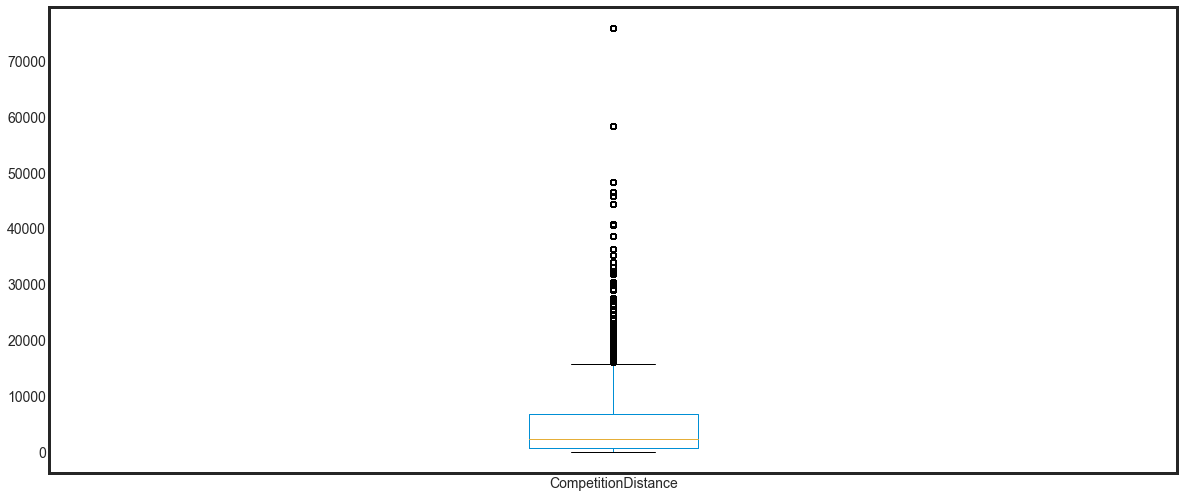

In [15]:
train_store_df['CompetitionDistance'].plot(kind='box')

**There are 6 columns with Missing Values in Train data and 7 columns in Test data**

Since it analysis, fixing missing values will skew our results depending on how large the missing values are. So i will drop those rows with missing values

In [16]:
# check out rows with missing columns
train_store_df[train_store_df.isna().any(axis=1)].tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1
1017208,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2,2013-01-01,0,0,0,0,a,1


In [17]:
# Fix Missing columns
fix_missing(train_store_df, missing_columns)

# fix missing for test
fix_missing(test_store_df, missing_columns)


# fix outliers
train_store_df['Customers'] = fix_outlier(train_store_df, 'Customers')
train_store_df['CompetitionDistance'] = fix_outlier(train_store_df, 'CompetitionDistance')

# fix outliers for test
test_store_df['CompetitionDistance'] = fix_outlier(test_store_df, 'CompetitionDistance')


**After Fixing Outliers**

<AxesSubplot:>

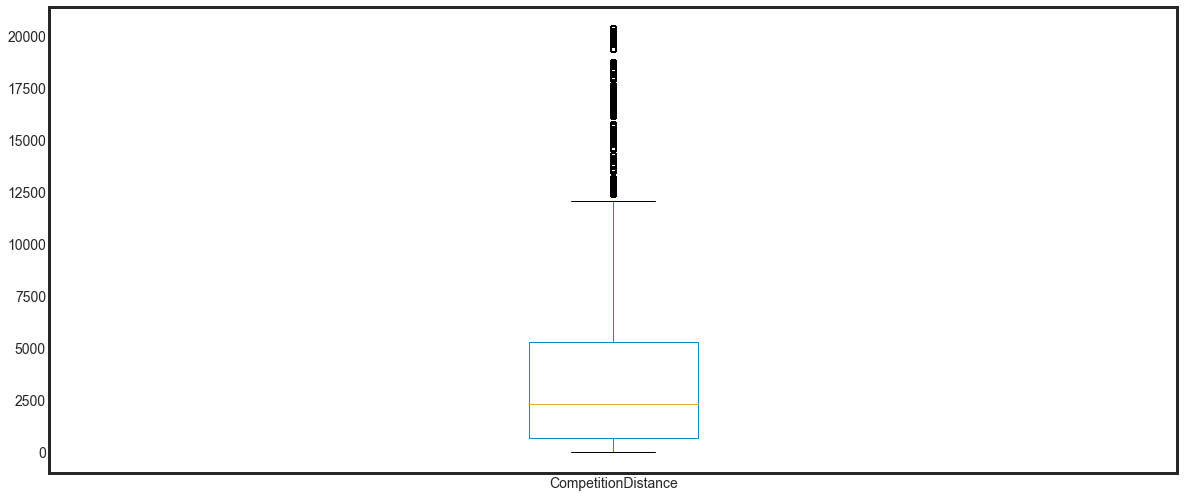

In [18]:
train_store_df['CompetitionDistance'].plot(kind='box')

>Coverting the Date column into a datetime object

In [19]:
# For Training and Testing
train_store_df['Date'] = pd.to_datetime(train_store_df['Date'])

test_store_df['Date'] = pd.to_datetime(test_store_df['Date'])

**Extract More Features from the Date Features for both Train and Test Sets**

In [20]:
for attr in ['day', 'month', 'week', 'dayofweek', 'weekofyear', 'days_in_month',
             'is_month_start', 'is_month_end', 'dayofyear']:
    train_store_df[attr] = getattr(train_store_df['Date'].dt, attr)
    test_store_df[attr] = getattr(test_store_df['Date'].dt, attr)
    ############################ TRAIN #################################
    
train_store_df['year'] = train_store_df['Date'].dt.year
train_store_df['is_weekend'] = (train_store_df['dayofweek'] >= 5)*1
train_store_df['fortnight'] = train_store_df['day']%15
train_store_df['which_fortnight'] = train_store_df['day']//15

############################################ Test ###########################

test_store_df['year'] = test_store_df['Date'].dt.year
test_store_df['is_weekend'] = (test_store_df['dayofweek'] >= 5)*1
test_store_df['fortnight'] = test_store_df['day']%15
test_store_df['which_fortnight'] = test_store_df['day']//15

In [21]:
# consuming per customer
train_store_df['SalesPerCustomer'] = train_store_df['Sales'] / train_store_df['Customers']

## Data Exploration and Understanding

In [22]:
train_store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,day,month,week,dayofweek,weekofyear,days_in_month,dayofyear,year,is_weekend,fortnight,which_fortnight,SalesPerCustomer
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,844340.000000
mean,5.584297e+02,4.077756e+03,7.469899e+00,2.009107e+03,5.005638e-01,2.263526e+01,2.011876e+03,3.998341e+00,5.773819e+03,5.682254e+02,8.301067e-01,3.815145e-01,1.786467e-01,1.570279e+01,5.846762e+00,2.361551e+01,2.998341e+00,2.361551e+01,3.040555e+01,1.622764e+02,2.013832e+03,2.845630e-01,6.885870e+00,5.877946e-01,10.407885
std,3.219087e+02,4.797446e+03,2.677243e+00,4.986802e+00,4.999999e-01,9.993137e+00,1.182965e+00,1.997391e+00,3.849926e+03,3.352674e+02,3.755392e-01,4.857586e-01,3.830564e-01,8.787638e+00,3.326097e+00,1.443338e+01,1.997391e+00,1.443338e+01,8.908046e-01,1.016162e+02,7.773960e-01,4.512063e-01,4.334036e+00,5.827503e-01,4.088154
min,1.000000e+00,2.000000e+01,1.000000e+00,1.900000e+03,0.000000e+00,1.000000e+00,2.009000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.800000e+01,1.000000e+00,2.013000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.800000e+02,7.100000e+02,6.000000e+00,2.008000e+03,0.000000e+00,2.200000e+01,2.012000e+03,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,3.000000e+00,1.100000e+01,1.000000e+00,1.100000e+01,3.000000e+01,7.700000e+01,2.013000e+03,0.000000e+00,3.000000e+00,0.000000e+00,8.102104
50%,5.580000e+02,2.330000e+03,8.000000e+00,2.010000e+03,1.000000e+00,2.200000e+01,2.012000e+03,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,6.000000e+00,2.200000e+01,3.000000e+00,2.200000e+01,3.100000e+01,1.530000e+02,2.014000e+03,0.000000e+00,7.000000e+00,1.000000e+00,9.558659
75%,8.380000e+02,5.330000e+03,9.000000e+00,2.011000e+03,1.000000e+00,2.200000e+01,2.012000e+03,6.000000e+00,7.856000e+03,7.800000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.300000e+01,8.000000e+00,3.500000e+01,5.000000e+00,3.500000e+01,3.100000e+01,2.410000e+02,2.014000e+03,1.000000e+00,1.100000e+01,1.000000e+00,11.393217
max,1.115000e+03,2.039000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03,7.000000e+00,4.155100e+04,1.362000e+03,1.000000e+00,1.000000e+00,1.000000e+00,3.100000e+01,1.200000e+01,5.200000e+01,6.000000e+00,5.200000e+01,3.100000e+01,3.650000e+02,2.015000e+03,1.000000e+00,1.400000e+01,2.000000e+00,68.228243


In [23]:
# change format to a more presentable format that is readable

In [24]:
def plot_chart(data, x_axis, y_axis, hue_column, legend=None):
    """
    Plot a bar plot to show distribution of values in x_axis
    x_axis : column to compare
    y_axis : values to see distribution
    
    return : barplot and a boxplot that is hued by dayofweek
    """
    plt.figure(figsize=(20, 9))
    sns.barplot(x=x_axis, y=y_axis, data=data ,hue=hue_column,)
    plt.title(f'Distribution of {y_axis} per {hue_column} for each {x_axis}', size=35); 
    plt.yticks(fontsize=25); plt.xticks(fontsize=25)    
    plt.legend(labels = legend, bbox_to_anchor=(1, 1.02), fontsize=20)


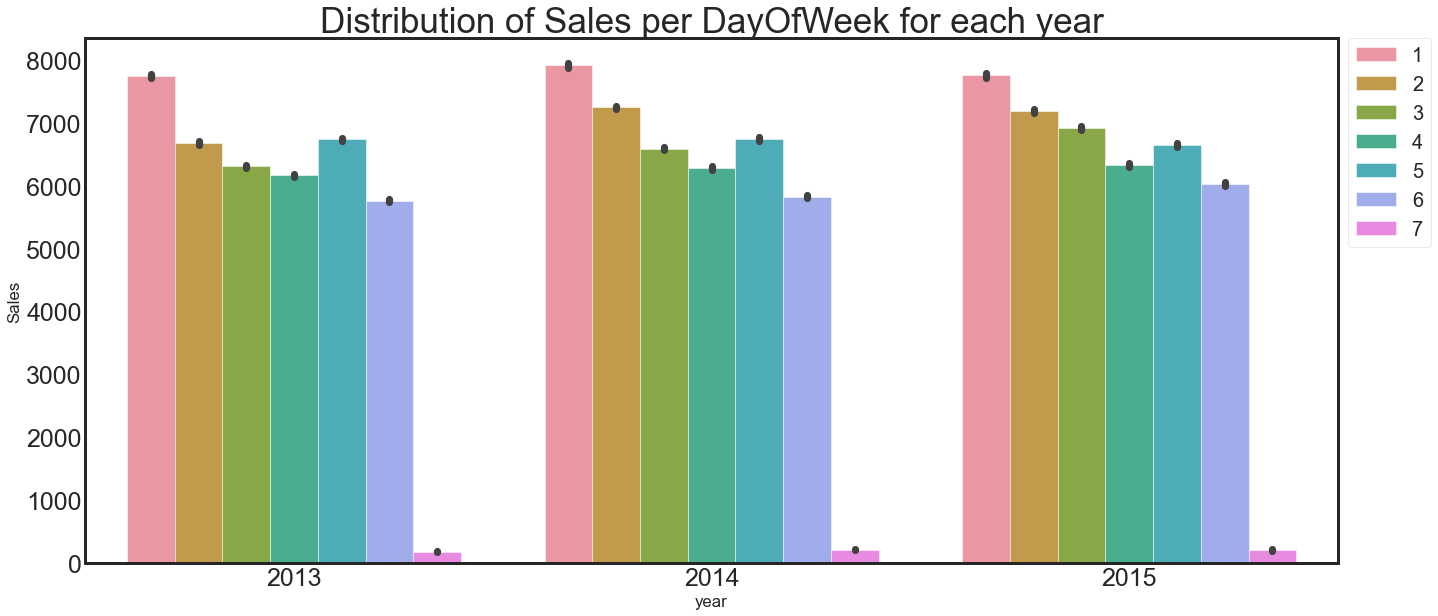

In [25]:
plot_chart(train_store_df, "year" , "Sales", "DayOfWeek")

There seems to be no sales on Day 7. It a Sunday and Shops were closed. Mondays is the day with the most Sales

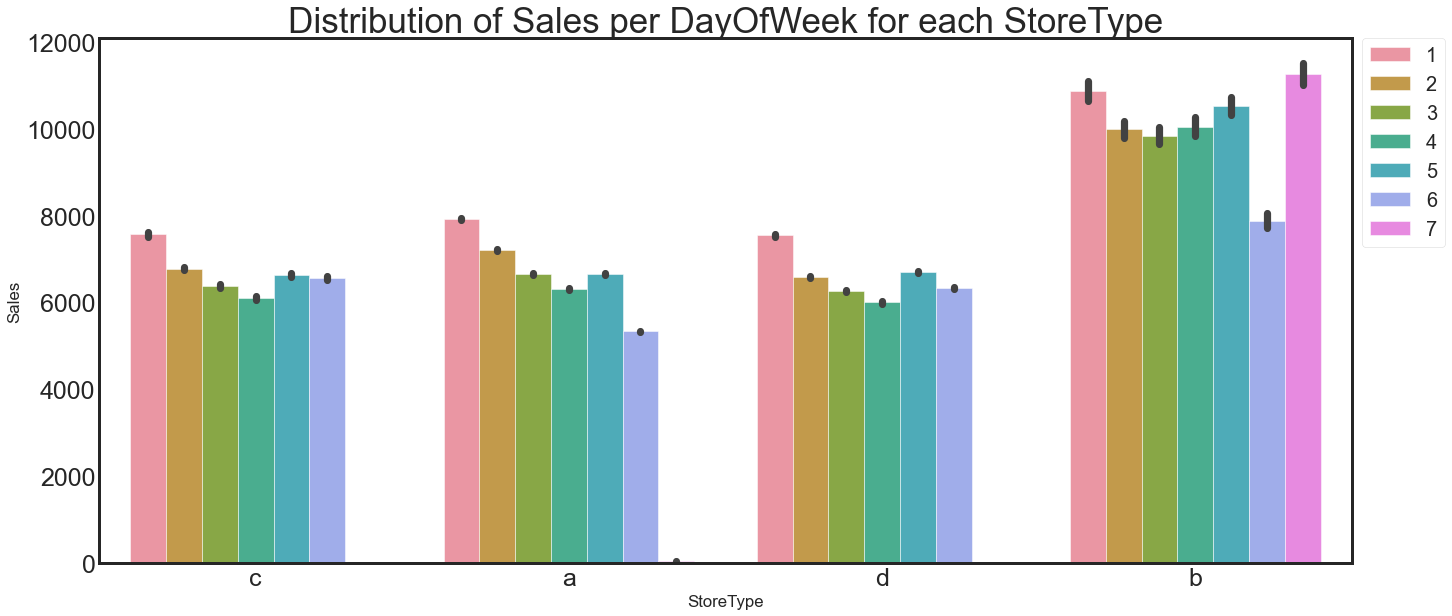

In [26]:
plot_chart(train_store_df, 'StoreType', 'Sales', "DayOfWeek")

**Check how the assortment type affects sales**

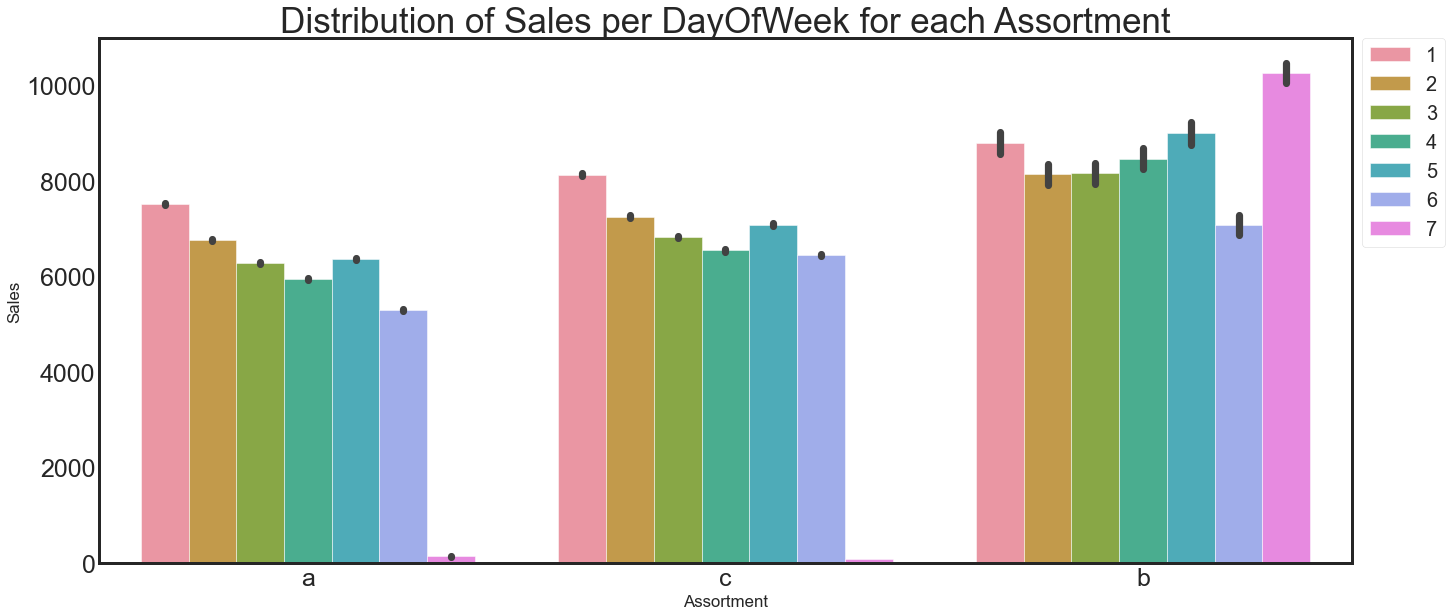

In [27]:
plot_chart(train_store_df, 'Assortment', 'Sales', hue_column="DayOfWeek")

1. Assortment b=Extra has the most recorded number of Sales per day and overall is the highest.
2. Assortment c=Extended has not recorded any sales on Sunday and Assortment a = basic has the lowest number of sales per day and overall.

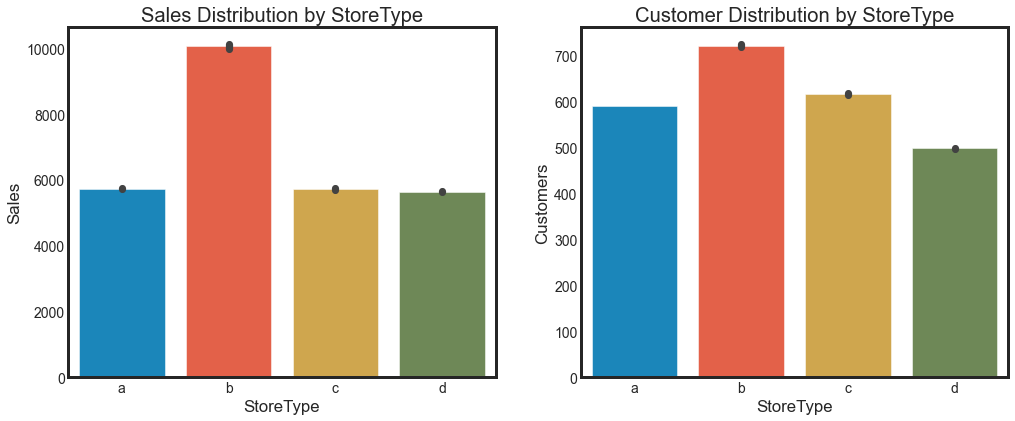

In [28]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,6))
sns.barplot(x='StoreType', y='Sales', data=train_store_df, order=['a','b','c', 'd'],ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=train_store_df, order=['a','b','c', 'd'], ax=axis2)
axis1.set_title('Sales Distribution by StoreType')
axis2.set_title('Customer Distribution by StoreType')
plt.show()

## $Time Series Analysis$

>**Check for seasonality in both training and test sets - are the seasons similar between these two groups?** 


Checking for Seasonality invloves doing a Time Series Analysis

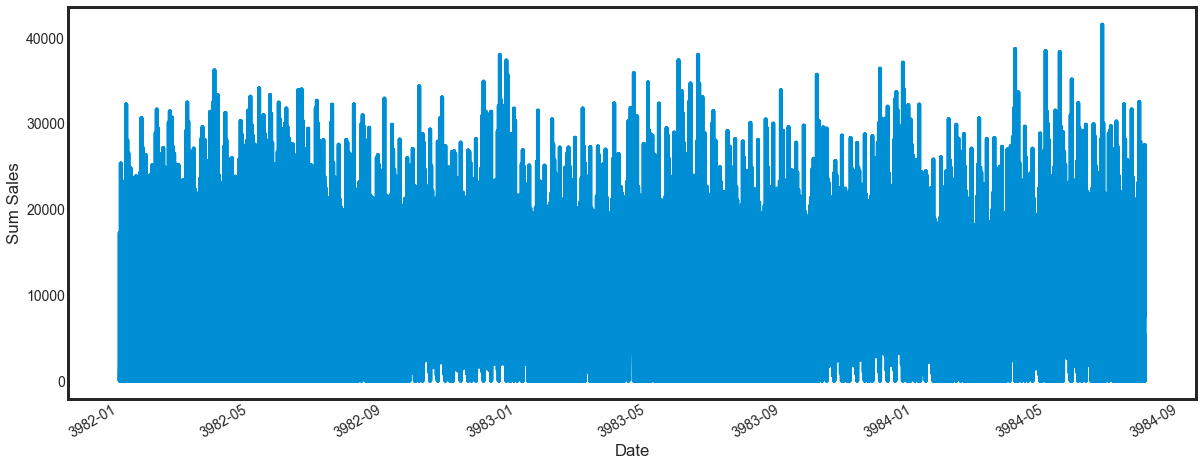

In [37]:
date_sales = pd.concat([train_data['Sales'], train_data['Date']], axis=1)
date_sales['Date'] = pd.to_datetime(date_sales['Date'])
date_sales = date_sales.set_index('Date').plot(legend=None)
plt.xlabel('Date')
plt.ylabel('Sum Sales')
plt.show()

The plot is not looking so good we can't pick any seasonal trend from it Hence, resampled the data by Months

In [29]:
def plot_trend(data, column):
    date_sales = pd.concat([data[column], data['Date']], axis=1)
    date_sales['Date'] = pd.to_datetime(date_sales['Date'])
    date_sales = date_sales.set_index('Date')
    fig, ax = plt.subplots(figsize=(18, 8))
    month_plot = date_sales.resample('M').sum()
    ax.plot(month_plot)
    ax.set(xlabel = 'Date', ylabel=f'Sum of {column} per Month',
          title='Trend of Sales by Months')
    plt.xticks(rotation=45, fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [30]:
def plot_trend_extended(data, group_column, column):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')

    store_a = data[(data[group_column] == 'a')]
    store_b = data[(data[group_column] == 'b')]
    store_c = data[(data[group_column] == 'c')]
    store_d = data[(data[group_column] == 'd')]

    store_a = store_a[column].resample('M').mean() 
    store_b = store_b[column].resample('M').mean()
    store_c = store_c[column].resample('M').mean()
    store_d = store_d[column].resample('M').mean() 

#     sns.set_style("dark")
    store_a.resample('M').mean().plot(legend=True, label='StoreType a')
    store_b.resample('M').mean().plot(legend=True, label='StoreType b')
    store_c.resample('M').mean().plot(legend=True, label='StoreType c')
    store_d.resample('M').mean().plot(legend=True, label='StoreType d')

    plt.xlabel('Date', fontsize=18)
    plt.ylabel(f'Average {column}', fontsize=18)
    plt.title(f'Trend of {column} per {group_column}', size=35)
    plt.show()

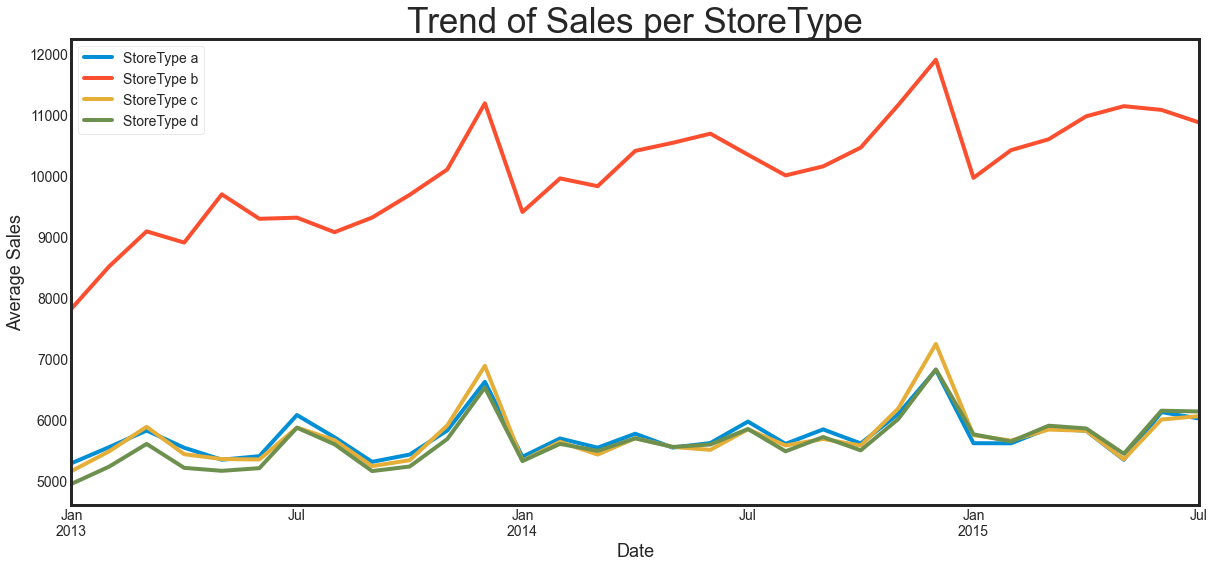

In [31]:
plot_trend_extended(train_store_df, group_column='StoreType', column='Sales')

**Store Type b made more Sales than any other stores every Month**

**All stores but store type b has similar trends for sales**

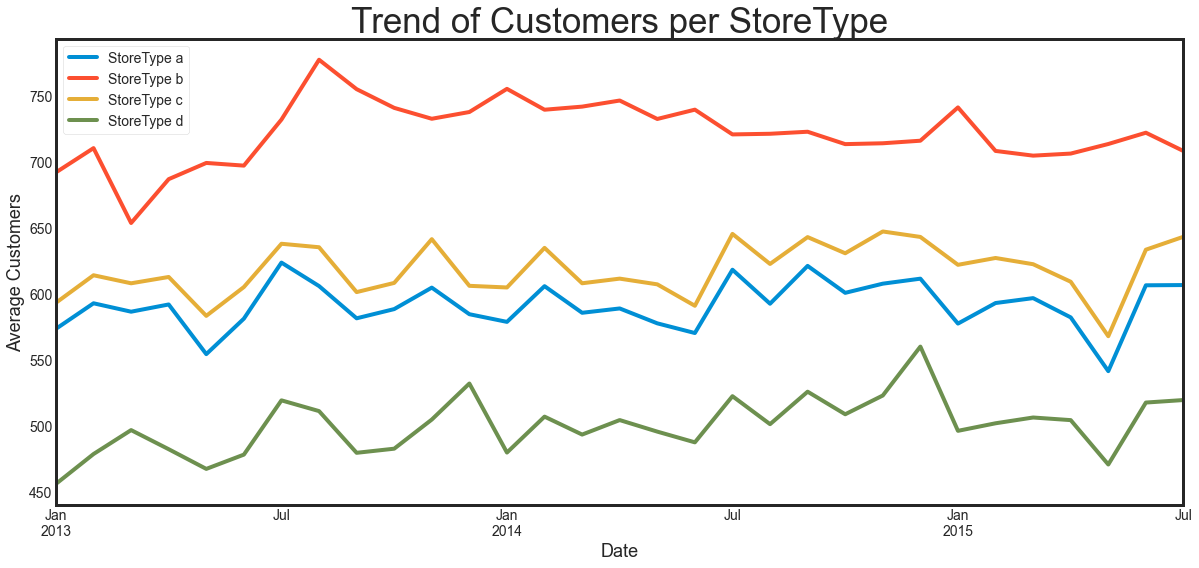

In [192]:
plot_trend_extended(train_store_df, group_column='StoreType', column='Customers')

1. **Store Type c and a has similar customer trends**

2. **Store Type b has the highest number of customers with store type d having the least through out the life span of the train data**

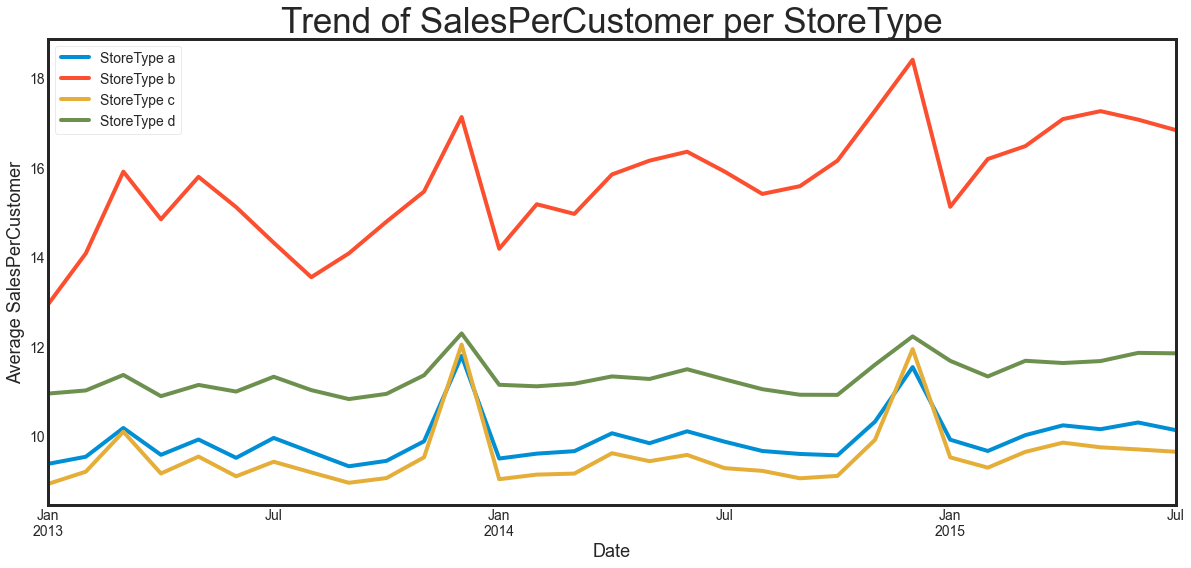

In [193]:
plot_trend_extended(train_store_df, group_column='StoreType', column='SalesPerCustomer')

1. **Store Type b has the highes ration for sales per customer**
2. **Despite store type d having the least number of customers for all months, it is the second to store type b with respect to sales per customer which means with few customers, it sells big.** This may be due to the kind of drug product store type d sells

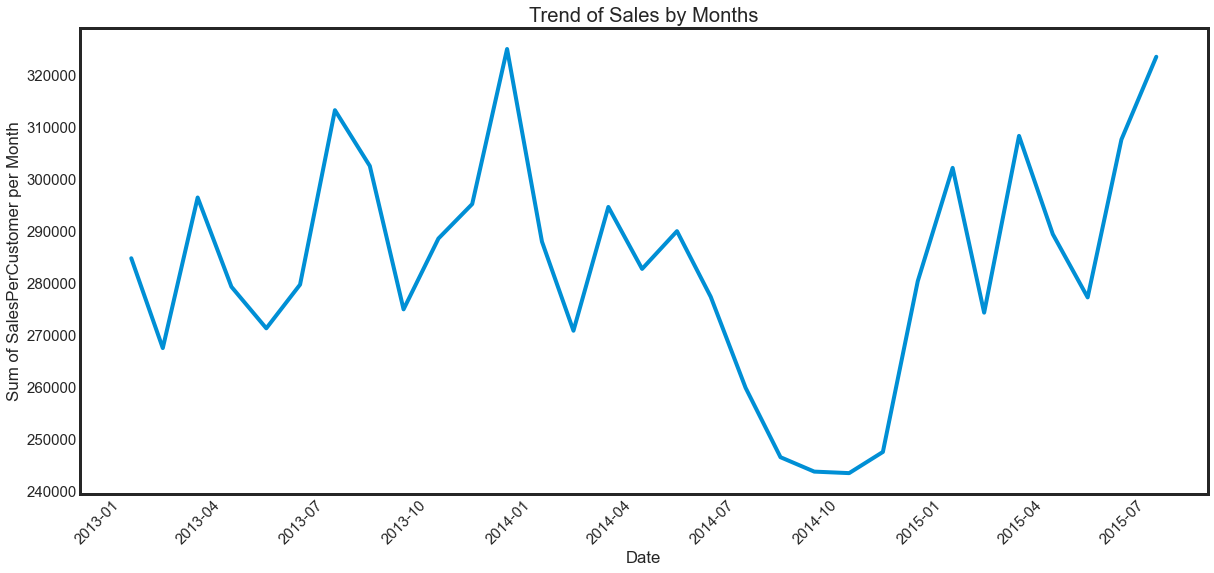

In [162]:
plot_trend(train_store_df, 'SalesPerCustomer')

A flat value for Sales was observed between the 8th month and 11th Month of 2014. What Happen in this months of 2014??

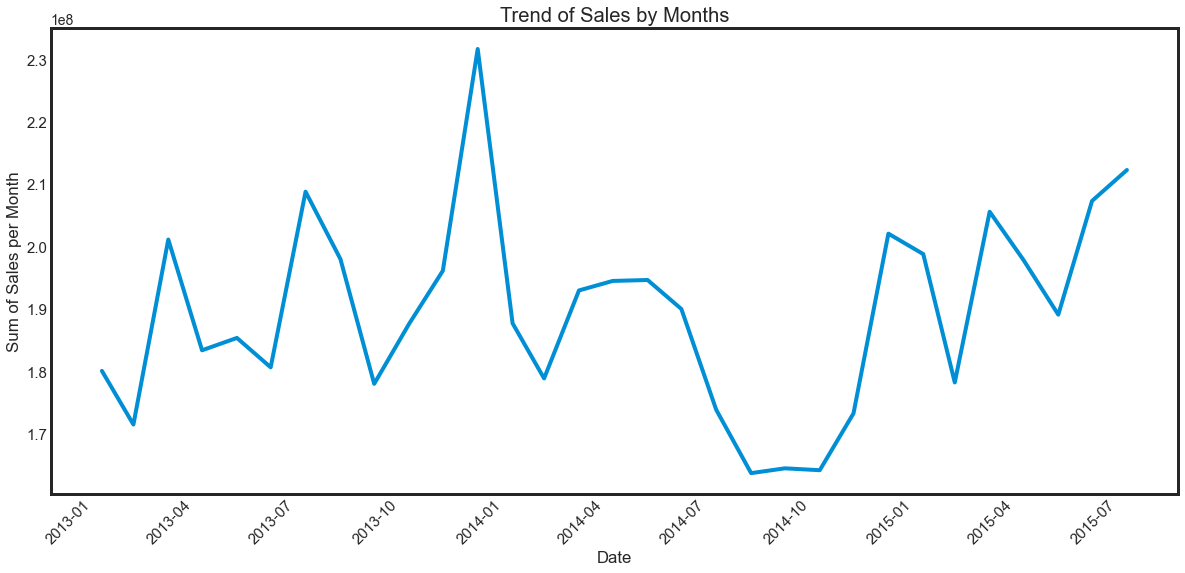

In [39]:
plot_trend(train_store_df, 'Sales')

There was an Upward Trend in 3rd Month till 4th Month of year 2013 before it dropped. There was a surge in Sales between the last month of 2013 and the beginning of 2014, it may be due to the Christmas Celebrations. A downward Trend can be observed the 7th Month (July) of 2014 till the 10th Month (October) 2014 and a rise in sales towards ending of 2014 till the beginning of 2015. There is Fluntuations in Sales between the 4th, 5th and 6th Month (April, May, June) before sales keeps a steady increase in the 7th Month (July) 2015.

**Trends Present in Training Data includes**
1. **Sales drops** every `3rd Month (March)` of the Years present in the Data (2013, 2014 and 2015)
2. **Fluntuation in Sales** between the `4th, 5th and 6th Month` every Year.
3. A **Significant increase** in Sales can be obsereved every *Last month* of the year and the beginning of the Year.

let verify if these trends can be observed in the test data

This will allow us build a reliable model to predict sales and we would be sure it a trend that occurs regularly not just a one off thing

In [40]:
# first verify the begining and end of the dates covered by the test data
display(test_store_df['Date'].min(), test_store_df['Date'].max())

Timestamp('2015-08-01 00:00:00')

Timestamp('2015-09-17 00:00:00')

Test Data covers 2 months of Sales. We might not get the complete trend as explained by the train data. Based on the trend we can observe in our train data there might be a significant drop in sales between teh 8th and 9th Month covered in our test data. Model Building part will explain this better

>**Check & compare sales behavior before, during and after holidays**

In [163]:
holiday_df = train_store_df.query('SchoolHoliday == 1')
not_holiday_df = train_store_df.query('SchoolHoliday == 0')

In [164]:
display(holiday_df.shape, not_holiday_df.shape)

(181721, 32)

(835488, 32)

We have 181721 observations for holidays

Let Plot the trend and compare sales by month during holiday

'Holiday Data'

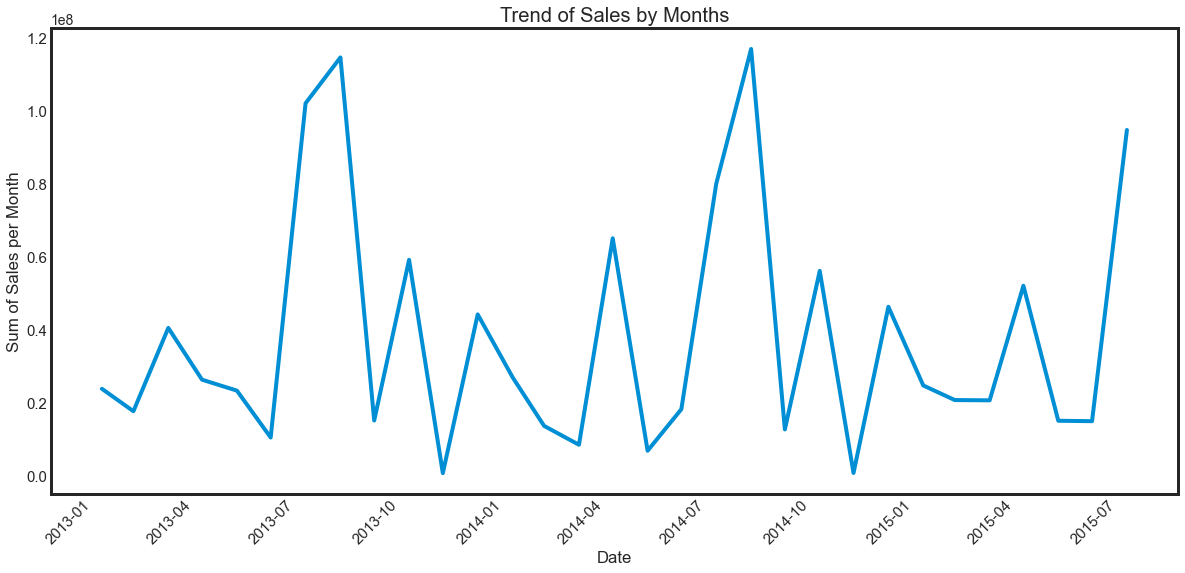

In [49]:
display('Holiday Data')
plot_trend(holiday_df, 'Sales')

The Trend here is similar to what we observed initially

Total Sales during Holiday is low when compared with no Holidays

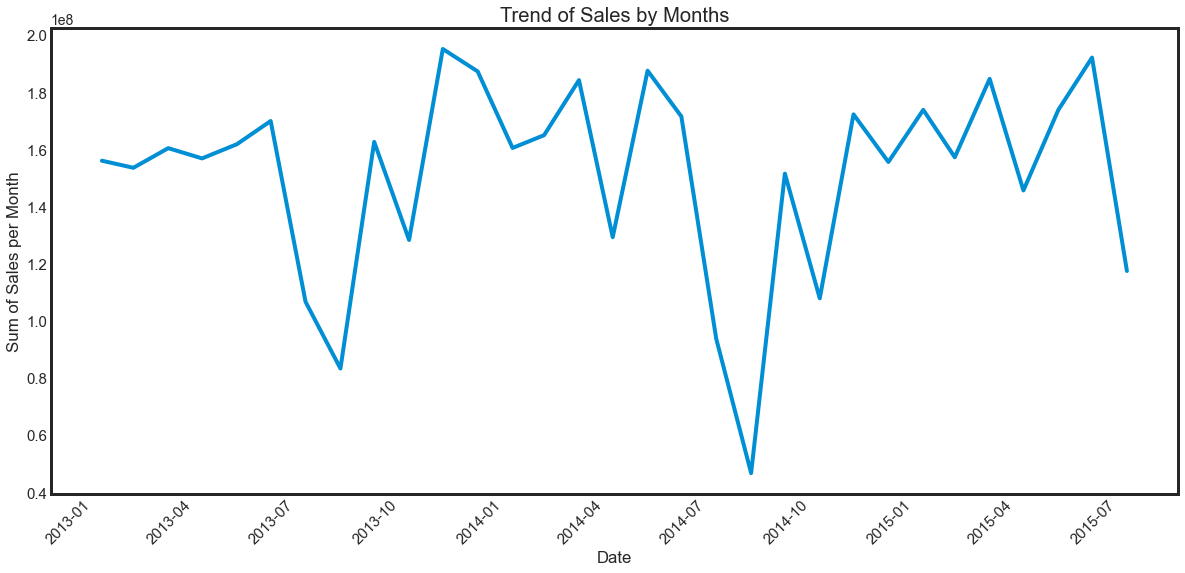

In [165]:
plot_trend(not_holiday_df, 'Sales')

Total Sales is high when no holidays

There was a drastic fall in sales on the 9th Month of year 2014 before improving and increases by a significant value in the 10th month of the same year

Let Check for Sales per Customer by months during holidays 

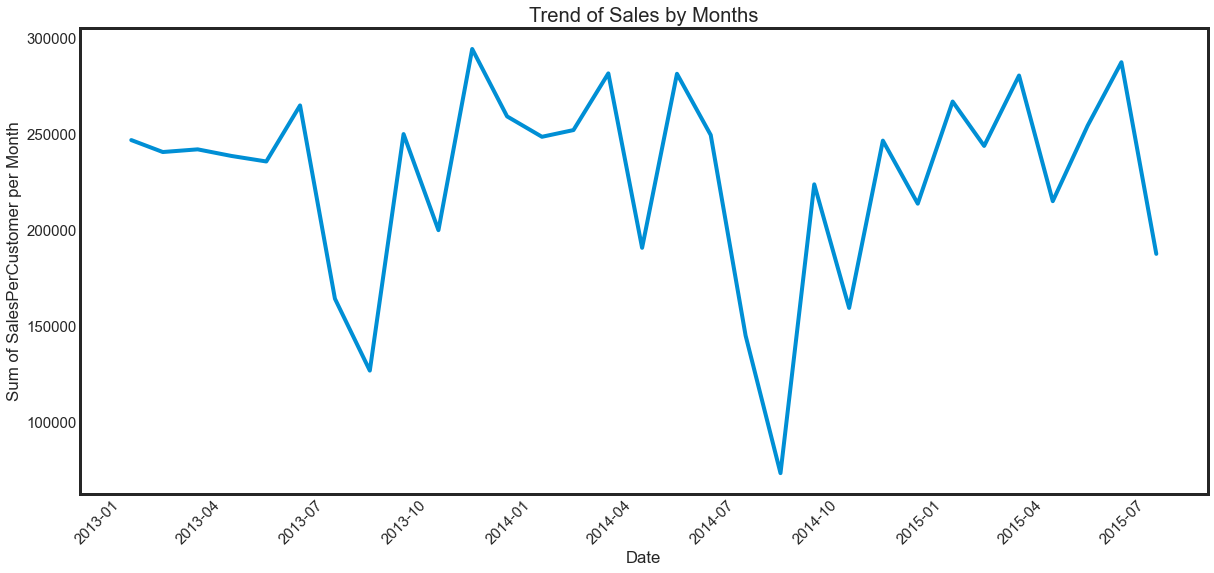

In [169]:
plot_trend(not_holiday_df, 'SalesPerCustomer')

Similar Trend can be observed. So to explain the drastic drop in sales between the 7th and the 9th month of 2014 i explored some Kaggle descriptions about the data and found out that it was intentionally left out of the training data. The discussion can be found https://www.kaggle.com/c/rossmann-store-sales/discussion/17048#96921 here

> **Find out any seasonal (Christmas, Easter etc) purchase behaviours**

'Holiday Data Christmas (12th Month)'

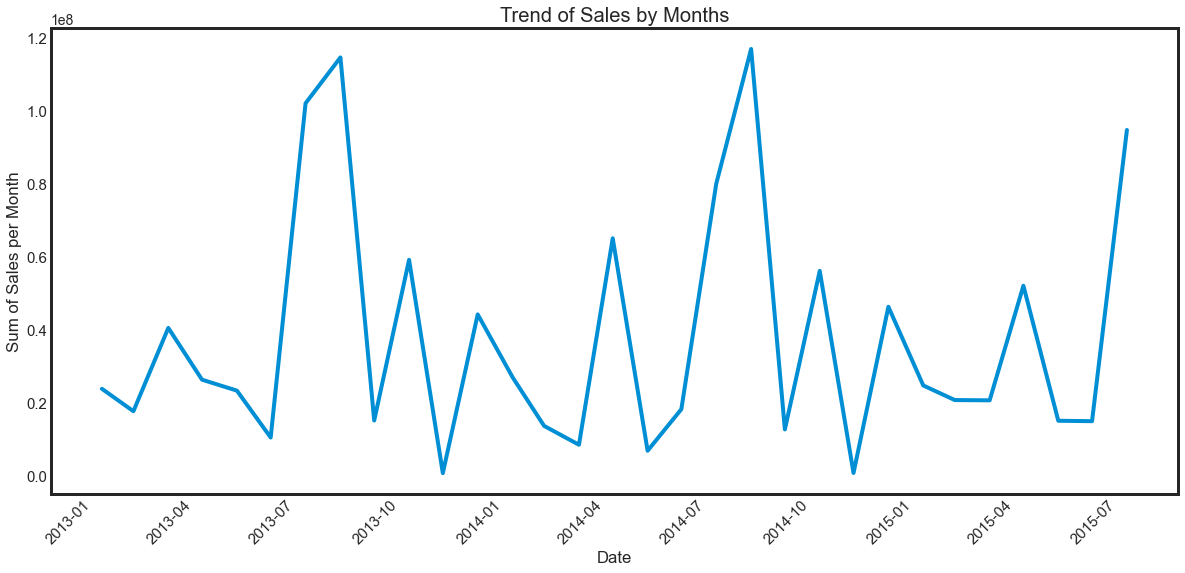

In [69]:
display('Holiday Data Christmas (12th Month)')
plot_trend(holiday_df, 'Sales')


Little or No Sales were recorded on **Chritmas Day**. For **Easter**, year 2014 of April (4th) Month had an increase in Sales for the Month. Same thing can be said for year 2015 of the 4th Month April. Sales reached it Peak or Maximum on every 7th Month (July) of the year 2013 and 2014.

**Let Analyze for State Holidays which Involves Easter and Christmas**

In [105]:
state_holiday_public = train_store_df.query('StateHoliday == "a"')
state_holiday_christmas = train_store_df.query('StateHoliday == "c"')
state_holiday_easter = train_store_df.query('StateHoliday == "b"')

no_state_holiday = train_store_df.query('StateHoliday == 0 or StateHoliday == "0"')

display(state_holiday_public.shape, state_holiday_christmas.shape, state_holiday_easter.shape,
        no_state_holiday.shape)

(20260, 31)

(4100, 31)

(6690, 31)

(986159, 31)

In [32]:
def plot_holiday_trend(column):
    sns.lineplot(x='Date', y=column, data=state_holiday_christmas, label='Christmas')
    sns.lineplot(x='Date', y=column, data=state_holiday_easter, label='Easter')
    sns.lineplot(x='Date', y=column, data=state_holiday_public, label='Public')
    plt.title('State Holidays Trends', size=35)
    plt.xlabel('Date', fontsize=20)
    plt.ylabel(f'{column}', fontsize=20)
    plt.xticks(rotation=45, fontsize=18)
    plt.legend(fontsize=16)
    plt.show()

There were Much Sales during Public Holidays than all other State Holidays

Only A few Customers were seen on Christmas Holidays and Easter. This is not the case for the public Holiday has large amount of customers visit the stores during public Holidays 

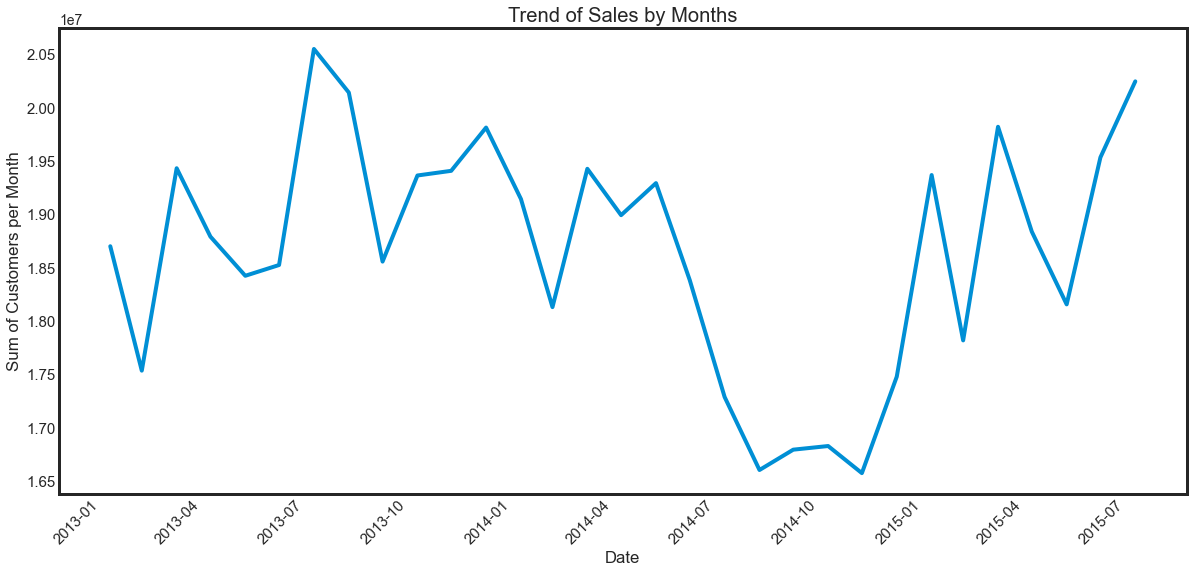

In [157]:
plot_trend(train_store_df, 'Customers')

'Holiday Data Easter (4th Month)'

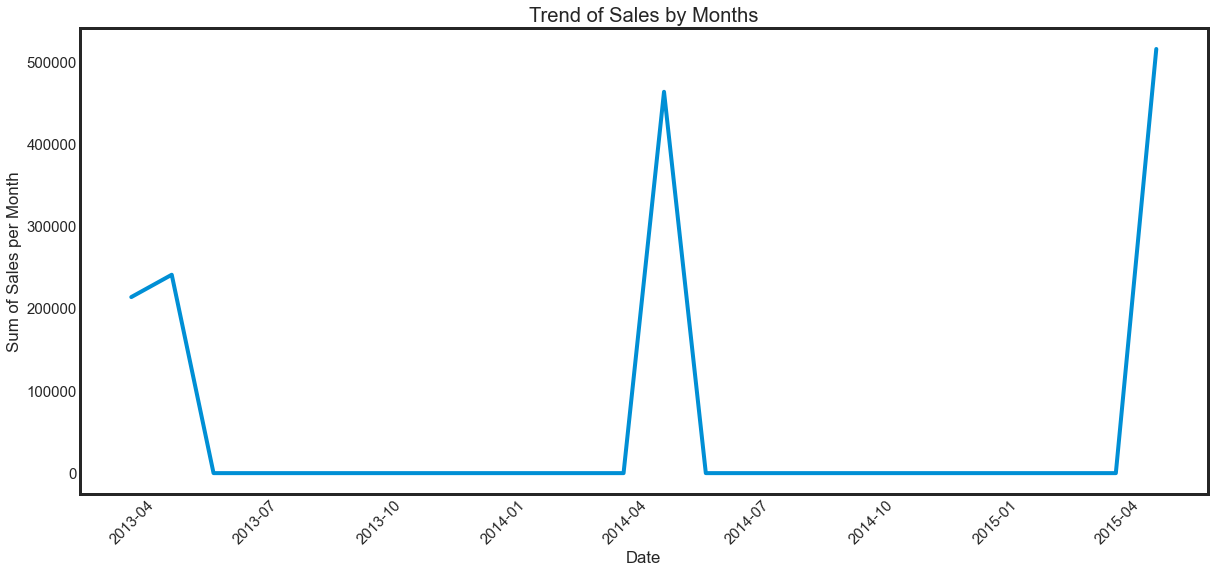

In [109]:
display('Holiday Data Easter (4th Month)')
plot_trend(state_holiday_easter, 'Sales')

'Holiday Data Christmas (12th Month)'

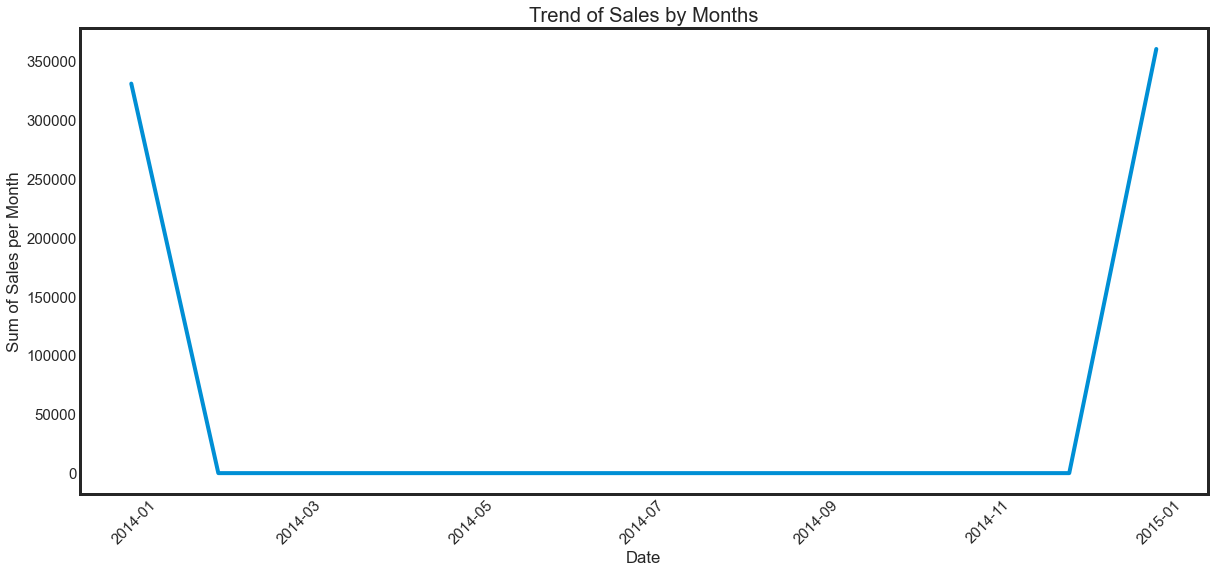

In [106]:
display('Holiday Data Christmas (12th Month)')
plot_trend(state_holiday_christmas, 'Sales')

<AxesSubplot:xlabel='Date', ylabel='Sales'>

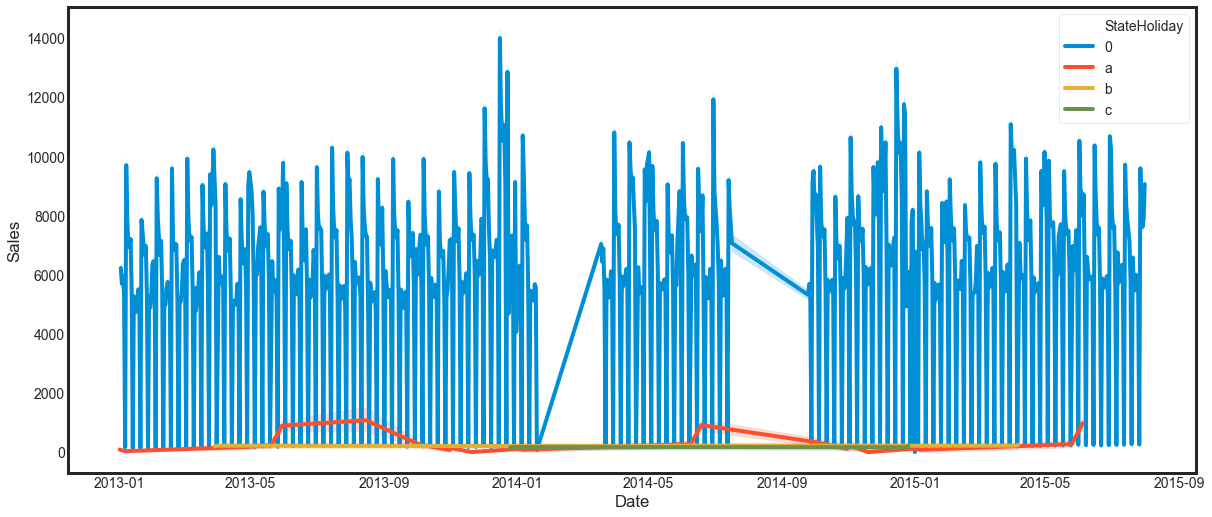

In [107]:
sns.lineplot(data=train_store_df, x='Date', y='Sales', hue='StateHoliday')

>> **What can you say about the correlation between sales and number of customers?**

In [33]:
def plot_scatter(x_axis, y_axis, hue=None, title=None):
    fig, ax = plt.subplots(figsize=(18, 8))
    sns.scatterplot(x=x_axis, y=y_axis, hue=hue, data=train_store_df)
    ax.set(xlabel = f'{x_axis}', ylabel=f"{y_axis}", title=f'{title}')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

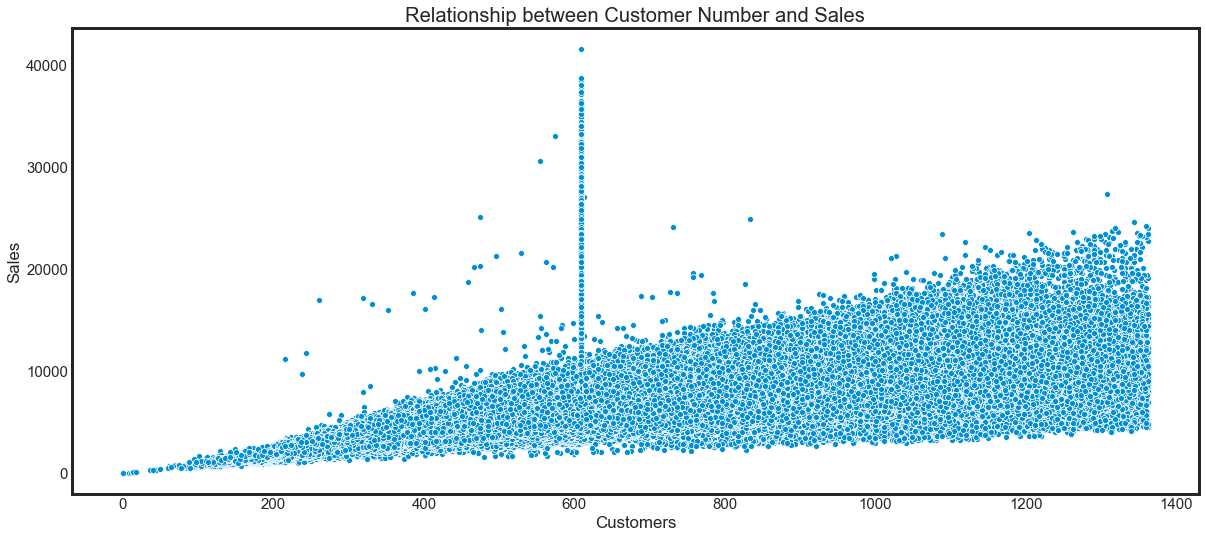

In [34]:
plot_scatter(x_axis='Customers', y_axis='Sales',
             title='Relationship between Customer Number and Sales')

There is a Linear Relationship between Sales and Customers which implies that the more customer present in store the more sales that will be made. There seems to be a max sale when customer number hit 600. Further Analysis is needed to unravel what happen. Up next...

Let Explore if sales are diffrent per day per customer. This will enable us know which day we have the most customer and further verify our assumption about linear relationships present between the Sales and Customers

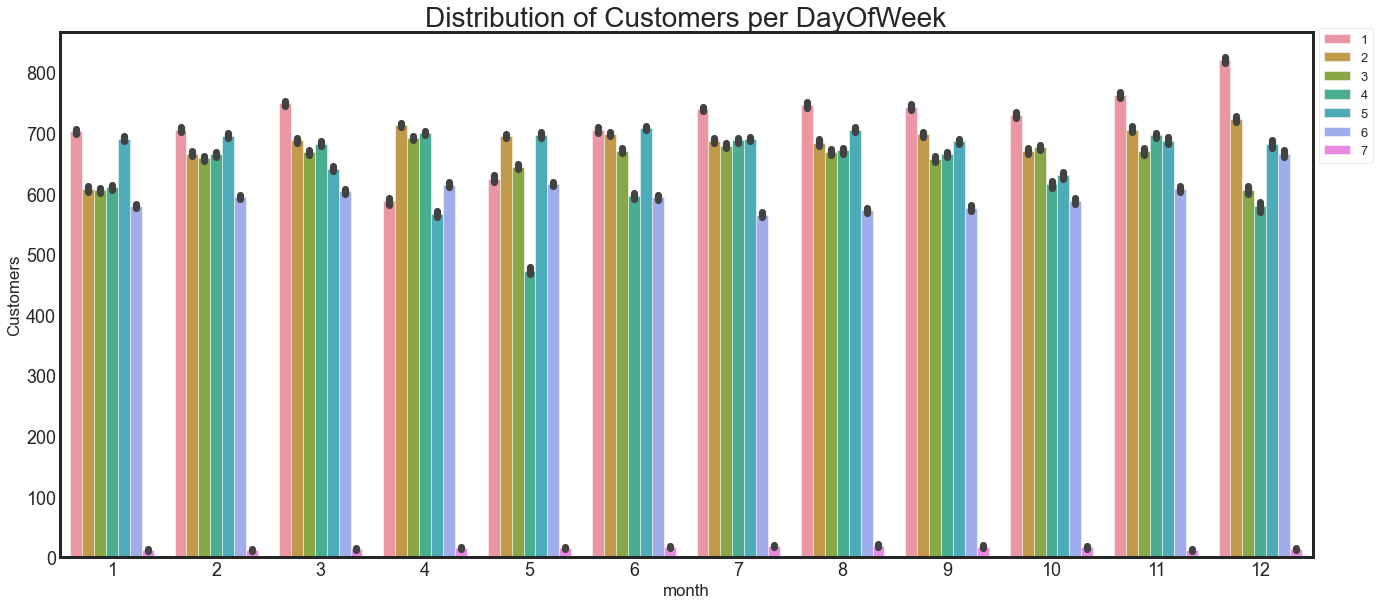

In [96]:
plot_chart(train_store_df, x_axis='month', y_axis='Customers', hue_column='DayOfWeek')

Most Sales happen during Monday and Thursdays

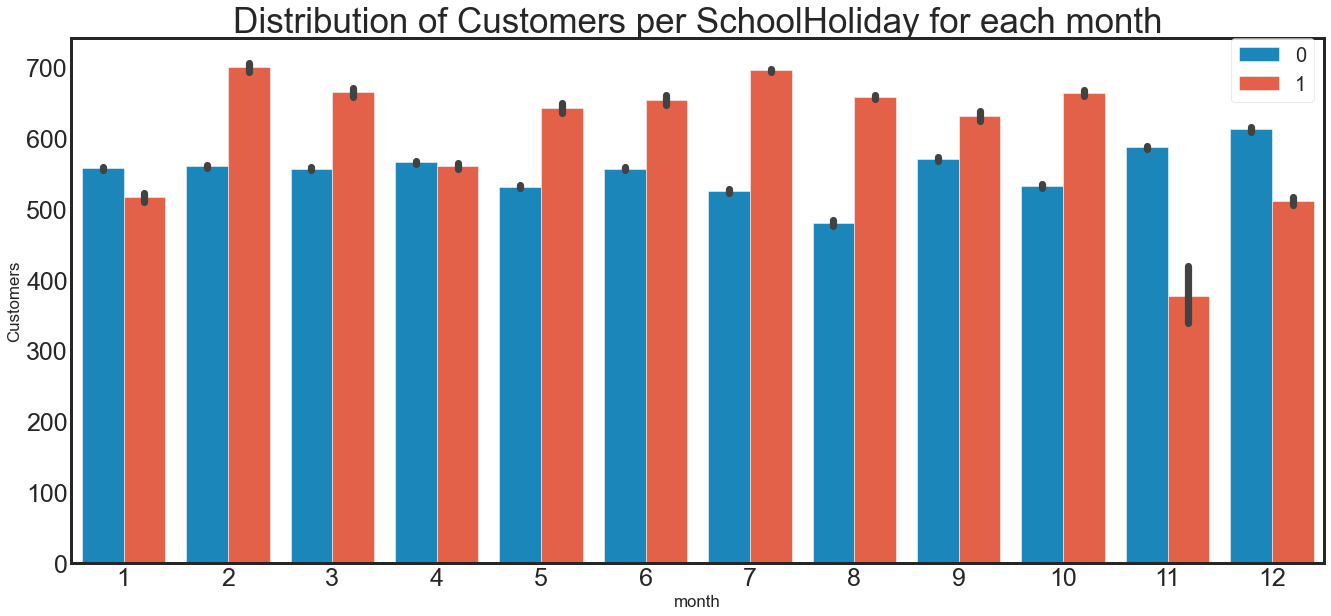

In [194]:
plot_chart(train_store_df, x_axis='month', y_axis='Customers', hue_column='SchoolHoliday')

More Customers were seen in the 11th, 12th and 1st Month during School Holidays. This shows that holidays provides more customers as well. Does this lead to more sales ?? let find out...

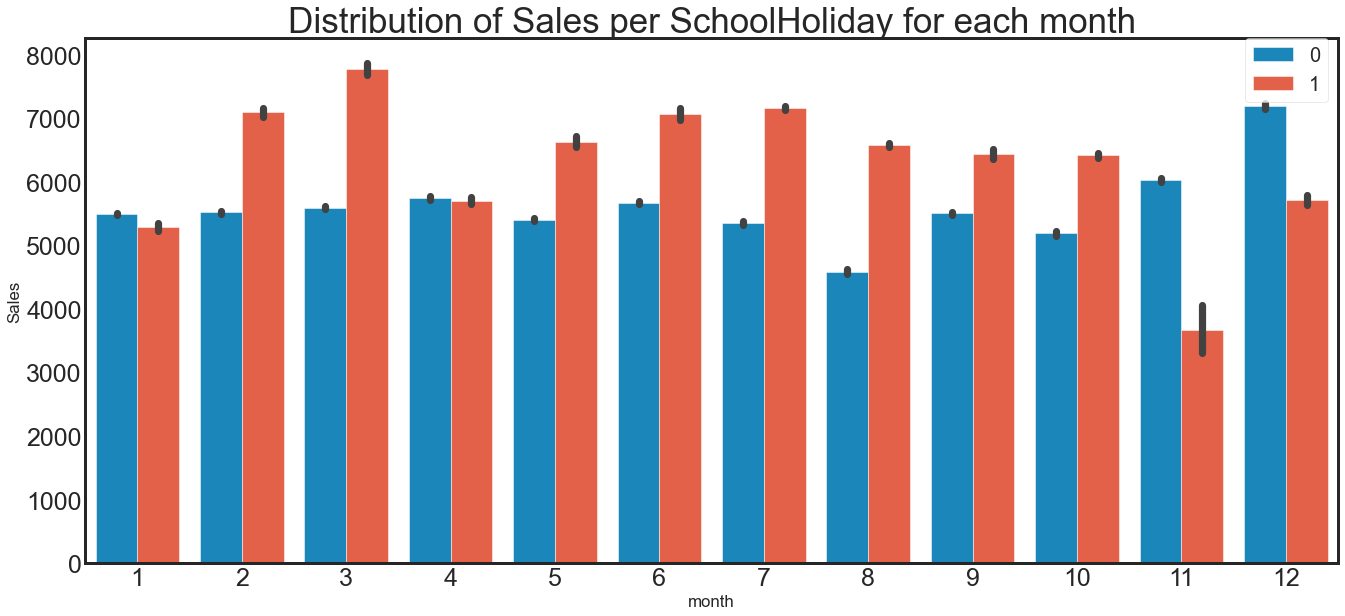

In [195]:
plot_chart(train_store_df, x_axis='month', y_axis='Sales', hue_column='SchoolHoliday',)

The result further proves our assumptions that more customers leads to more sales as the result is similar to what we have for the customer column.

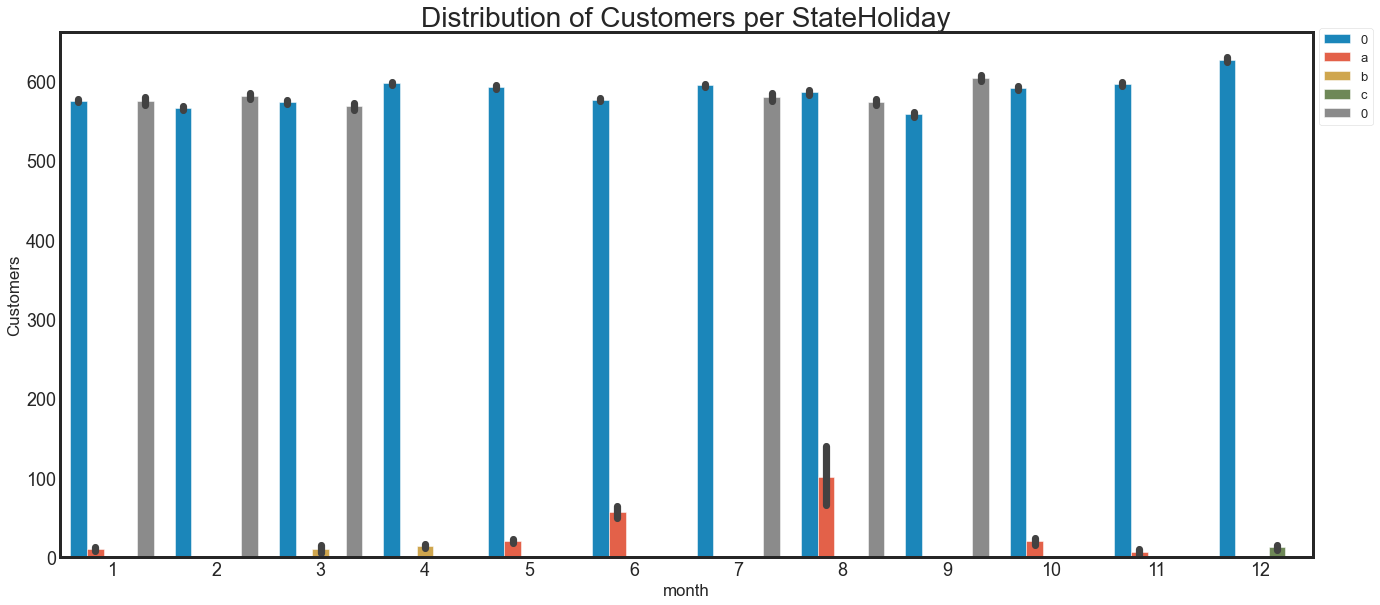

In [111]:
plot_chart(train_store_df, x_axis='month', y_axis='Customers', hue_column='StateHoliday',)

 We can Observe that

> **How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?** 


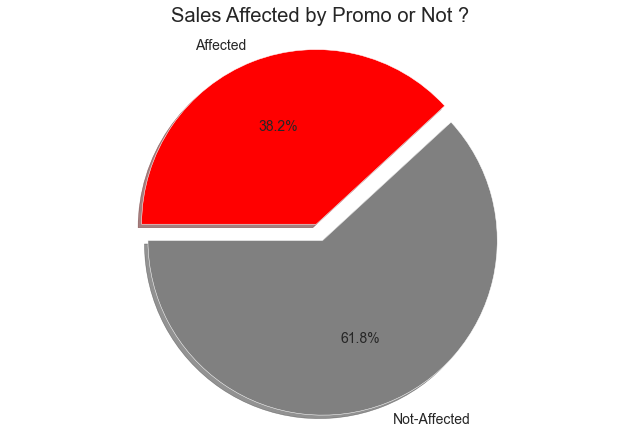

In [36]:
labels = 'Not-Affected' , 'Affected'
sizes = train_store_df.Promo.value_counts()
colors = ['grey', 'red']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Promo or Not ?")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(10,7)
plt.show()

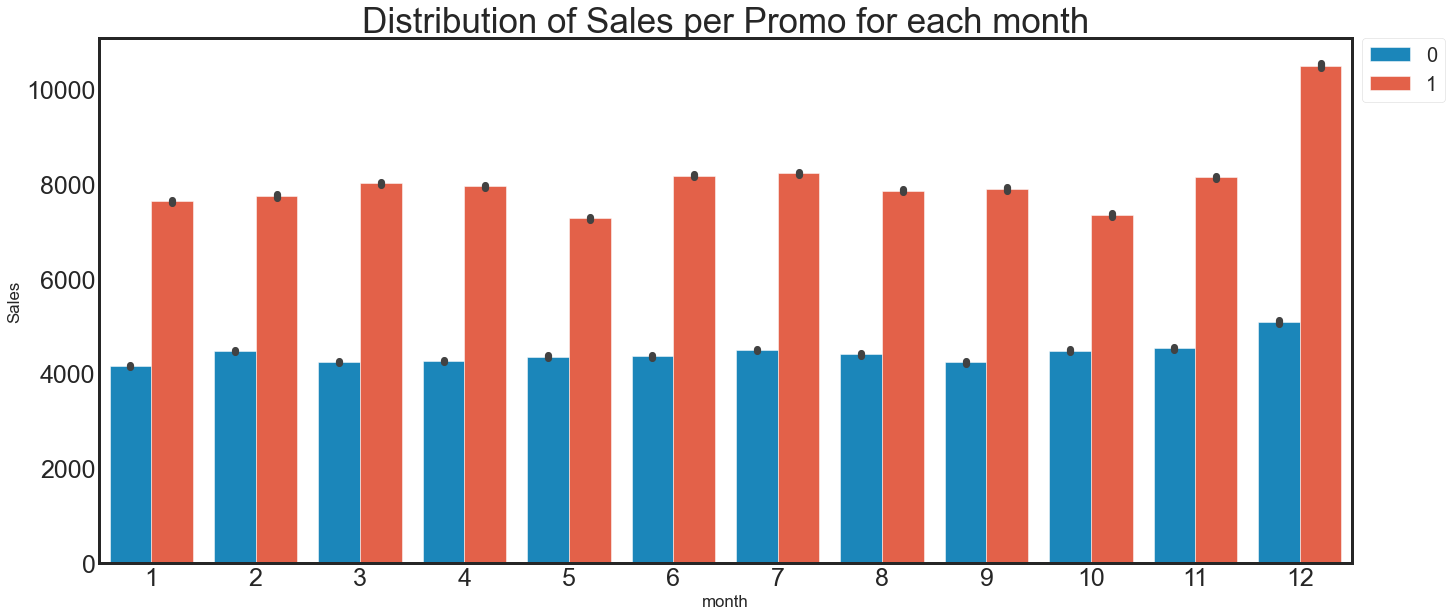

In [196]:
plot_chart(train_store_df, x_axis='month', y_axis='Sales', hue_column='Promo',)

During Promo, stores generate more sales and there is always a promo every month. Anytime there is no promo, average sales made per month is around approximately **4000** while when there is promo average sales is about **8000**. That is **Double sales** which is impressive.

In [119]:
avg_sales_promo = train_store_df.query('Promo == 1')['Sales'].mean()
avg_sales_no_promo = train_store_df.query('Promo == 0')['Sales'].mean()
print('Average Sales During Promo = ', avg_sales_promo)
print('Average Sales No Promo = ', avg_sales_no_promo)

Average Sales During Promo =  7991.152045969903
Average Sales No Promo =  4406.050805160786


**Based on Our Assumptions that more sales more customers and vice versa we can conclude that promo attracts more customers**

Already Customers will tend to stick to the store if the store keeps running promos every month. We can also break this down by checking when promos are run with number of customers per day...

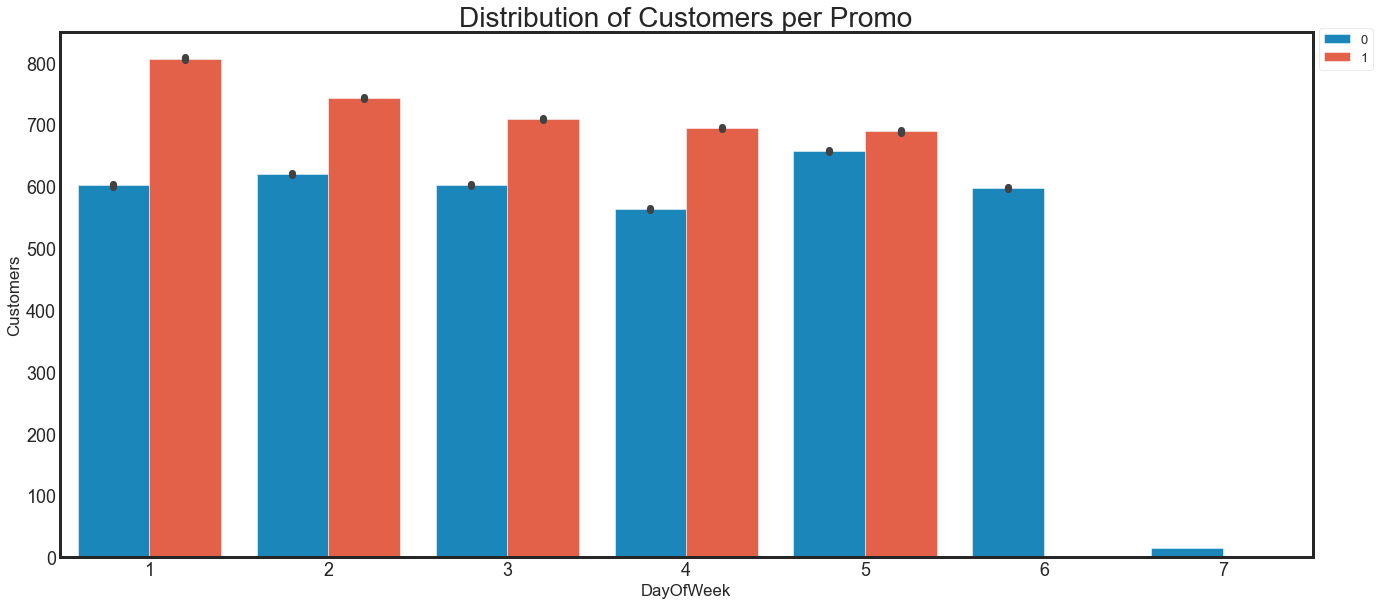

In [120]:
plot_chart(train_store_df, x_axis='DayOfWeek', y_axis='Customers', hue_column='Promo')

Already Customers will tend to come during the weekdays as they would be familiar with the routine of stores as to when they run their promos. From the chart above stores dont run promos on the 6th day (Saturday) and still make more sales than some other days like 4th day (Thursday). We can propose  that running a promo on the 6th day might lead to even more customers

<AxesSubplot:xlabel='PromoInterval', ylabel='Sales'>

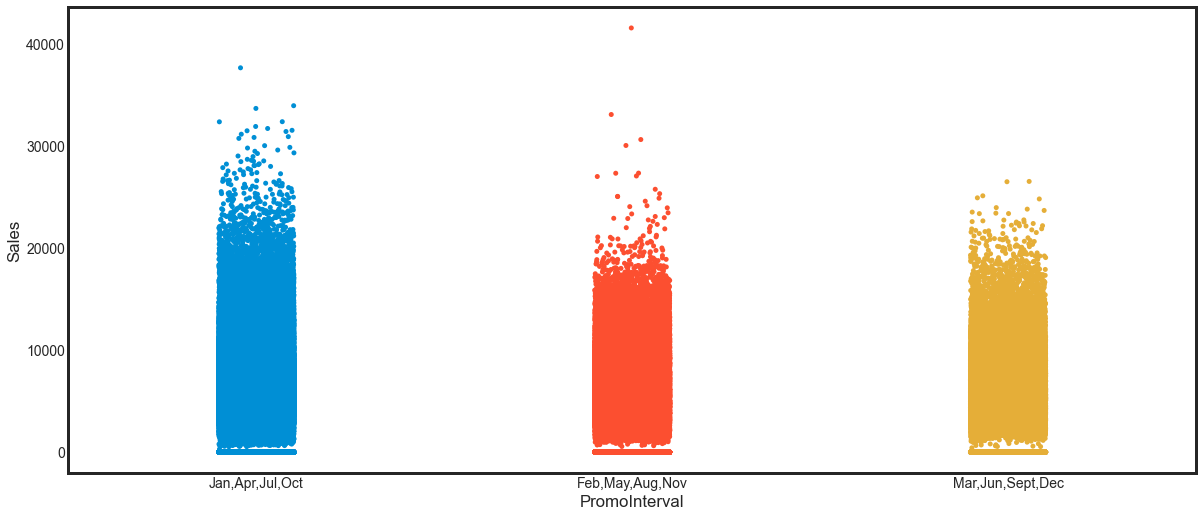

In [179]:
sns.stripplot(x='PromoInterval', y='Sales', data=train_store_df, jitter=True)

>**Could the promos be deployed in more effective ways? Which stores should promos be deployed in?**

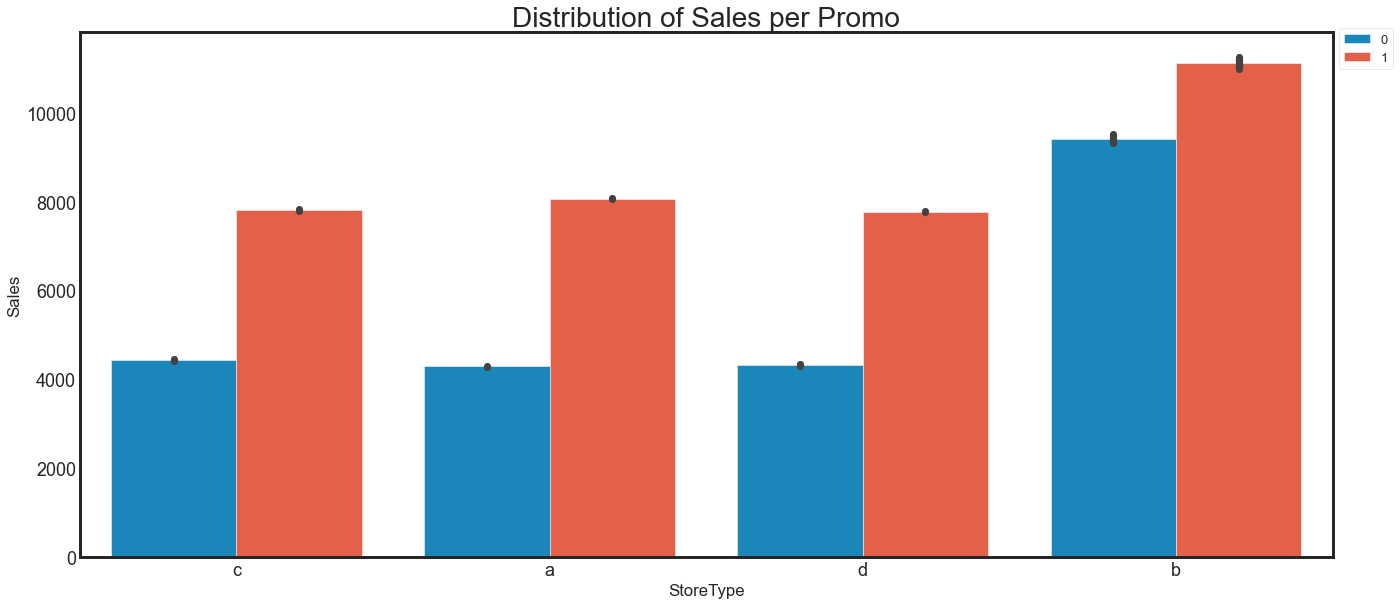

In [121]:
plot_chart(train_store_df, x_axis='StoreType', y_axis='Sales', hue_column='Promo')

Store Type d has a least of Sales between all the Stores and Store b has the highest. Since it just a little diffrence, i will advice promo should be encouraged more in store type d and promo in store b can be reduced alittle maybe by 0.3%. A test run will further clear this. 

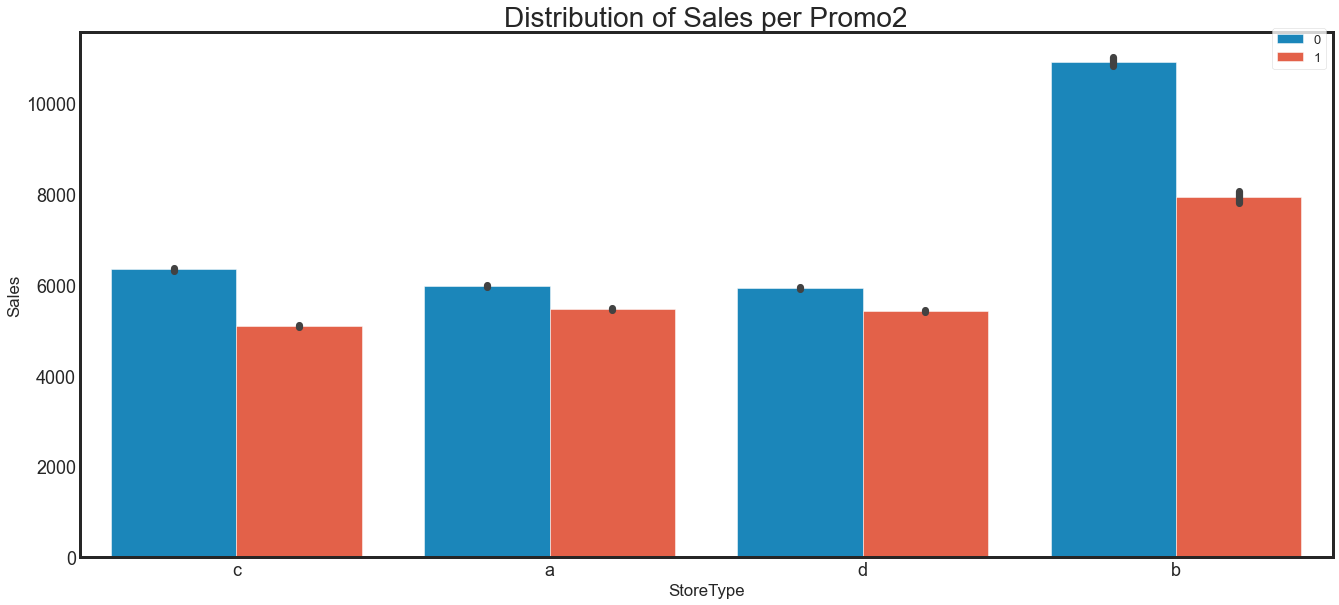

In [123]:
plot_chart(train_store_df, x_axis='StoreType', y_axis='Sales', hue_column='Promo2')

From this plot, it shows when store participate in promo continuations, the stores make less sales as compared to when they did not continue with the promotion. **This means that Promotions should only be run for a limited amount of time**

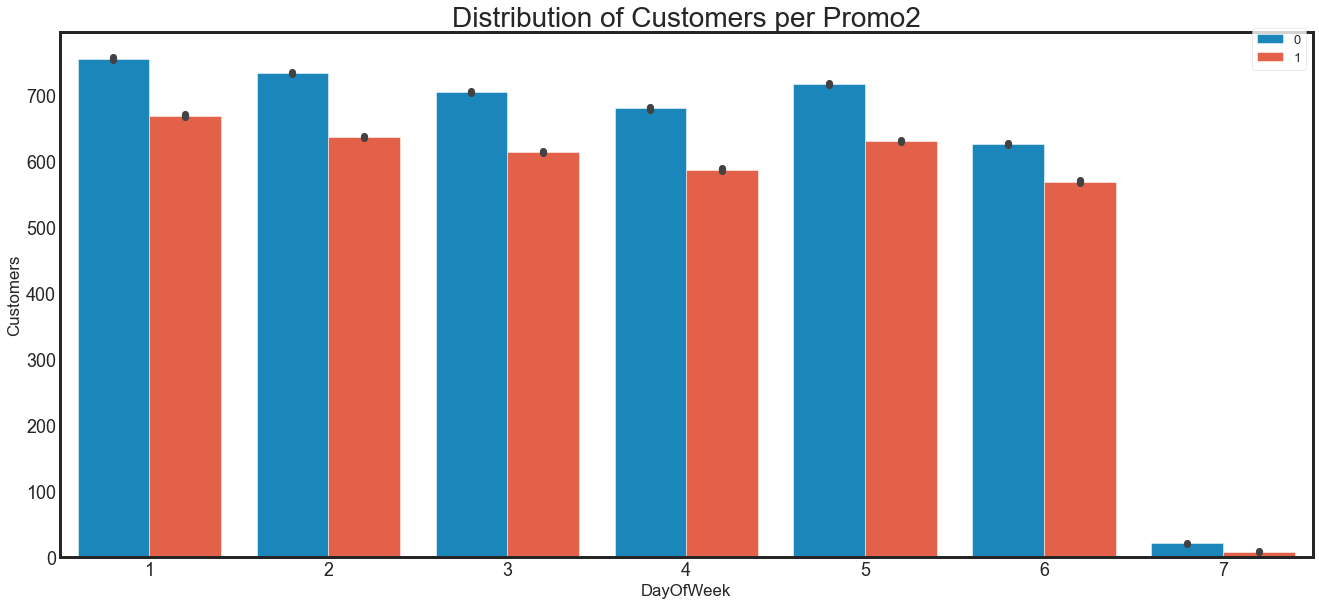

In [122]:
plot_chart(train_store_df, x_axis='DayOfWeek', y_axis='Customers', hue_column='Promo2')

More sales were made on Days where Promo was not continued. This further clear what i stated earlier that **Promos should only be run for a short period of time**

**Year Since Stores has been participating in Promo Continuation**

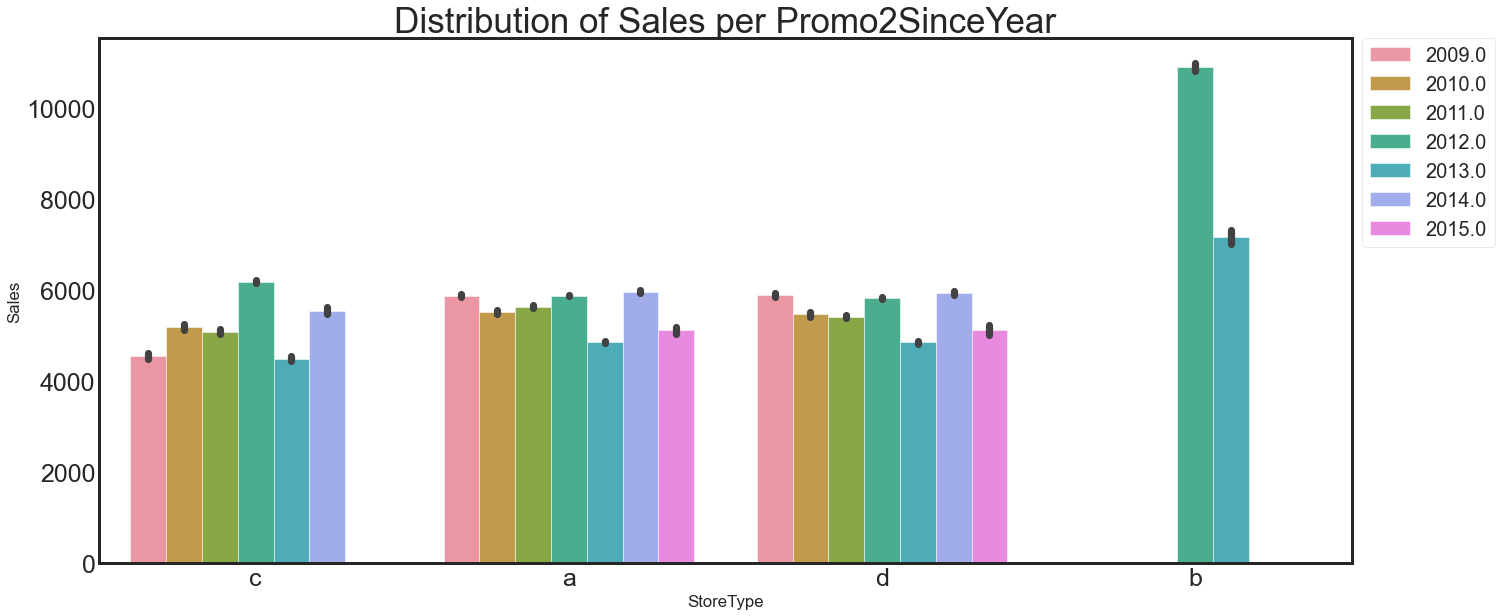

In [128]:
plot_chart(train_store_df, x_axis='StoreType', y_axis='Sales', hue_column='Promo2SinceYear')

Store b is doing very well in terms of Sales while other stores has almost the same average sales and they have been participating in the continuation of promotions since the beginning of the promo. So Promo in 2012 and 2013 seems to increase sales than other years for promotion continuations. Promo Continuation should be limited in store a, c and d and b should be kept as it is..

> **Trends of customer behavior during store open and closing times**

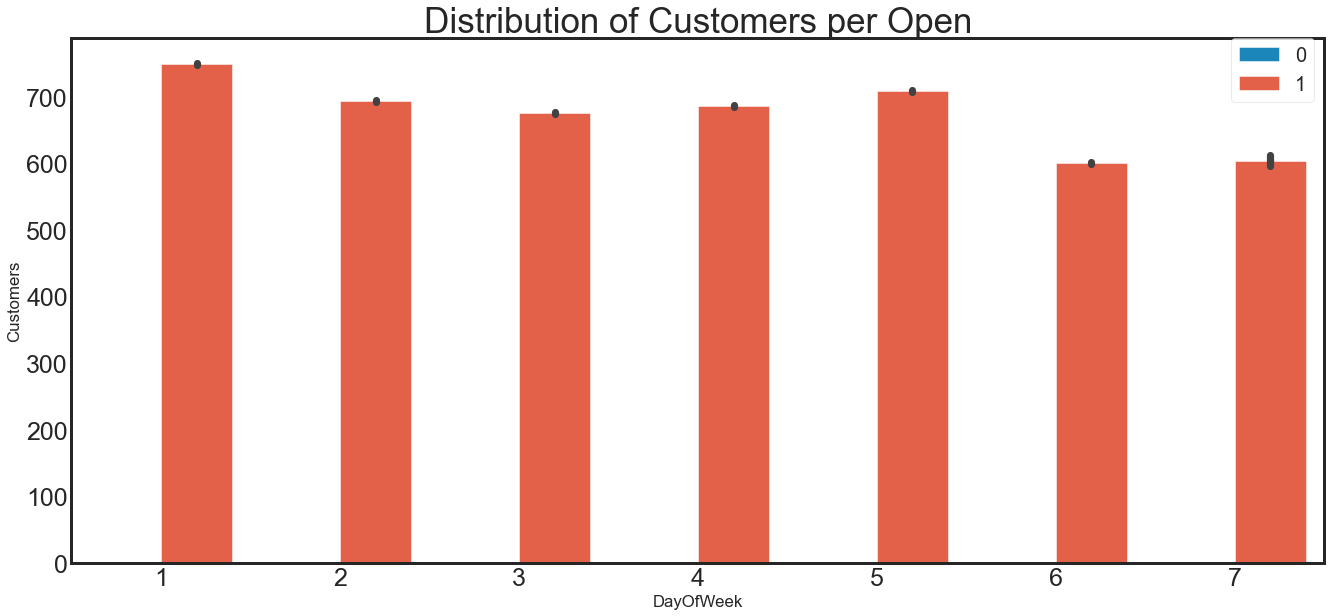

In [131]:
plot_chart(train_store_df, x_axis='DayOfWeek', y_axis='Customers', hue_column='Open')

> **Which stores are opened on all weekdays? How does that affect their sales on weekends?**

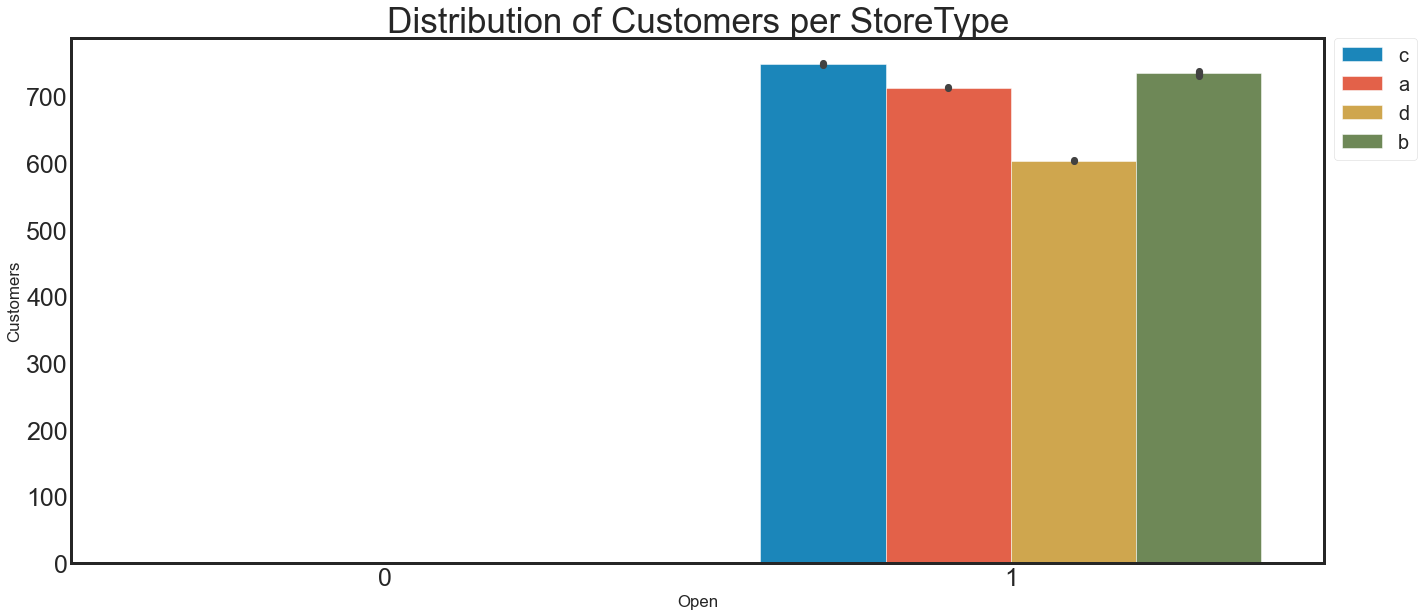

In [138]:
plot_chart(train_store_df, x_axis='Open', y_axis='Customers', hue_column='StoreType')

**All Store Types are open every Day of the Week**

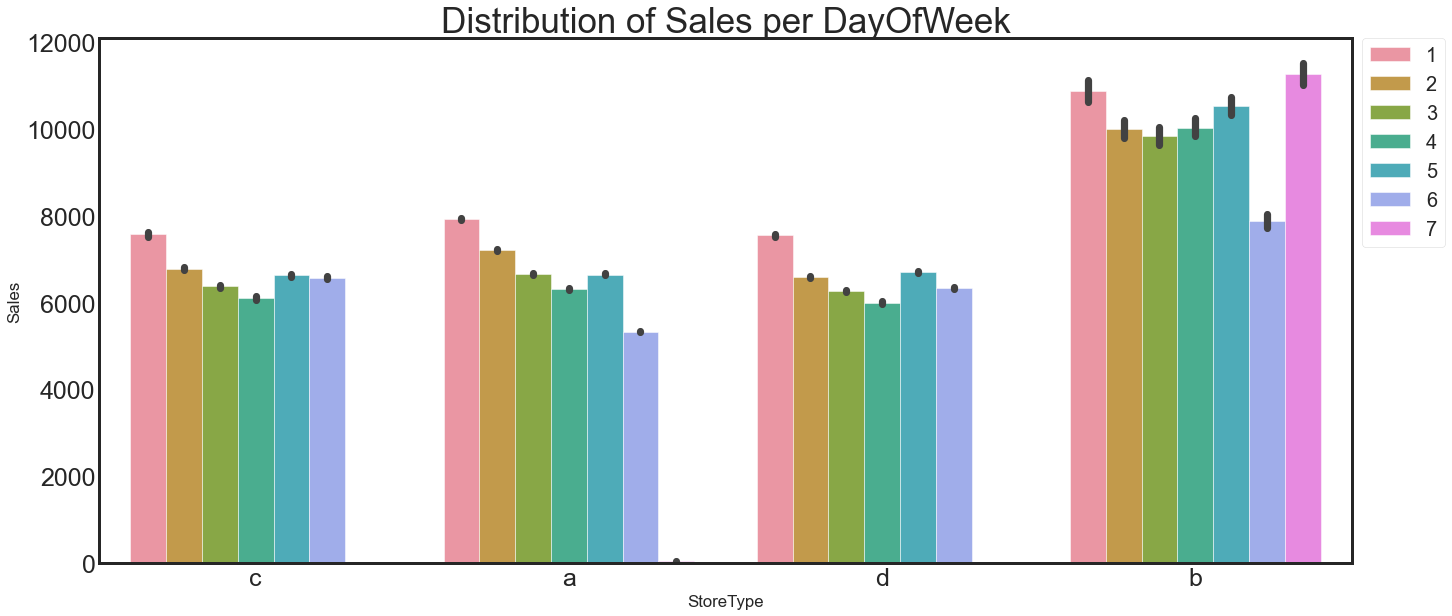

In [139]:
plot_chart(train_store_df, x_axis='StoreType', y_axis='Sales', hue_column='DayOfWeek')

Only Store Type B record sales on Sunday **(Weekend)** and it the highest sale of not just the store type b but also for store type a, c and d. This means that opening on all week days does not have a negative impact on all the stores ouput with respect to sales recorded but store type a c and d does not record any sale on this day (Sunday)

> **How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?**

Is there correlation between competition distance and sales?

In [149]:
np.corrcoef(train_store_df['Sales'], train_store_df['CompetitionDistance'])

array([[ 1.        , -0.03299706],
       [-0.03299706,  1.        ]])

I would argue there is no significant correlation between the 2 features **Sales and Comepetition Distance.**

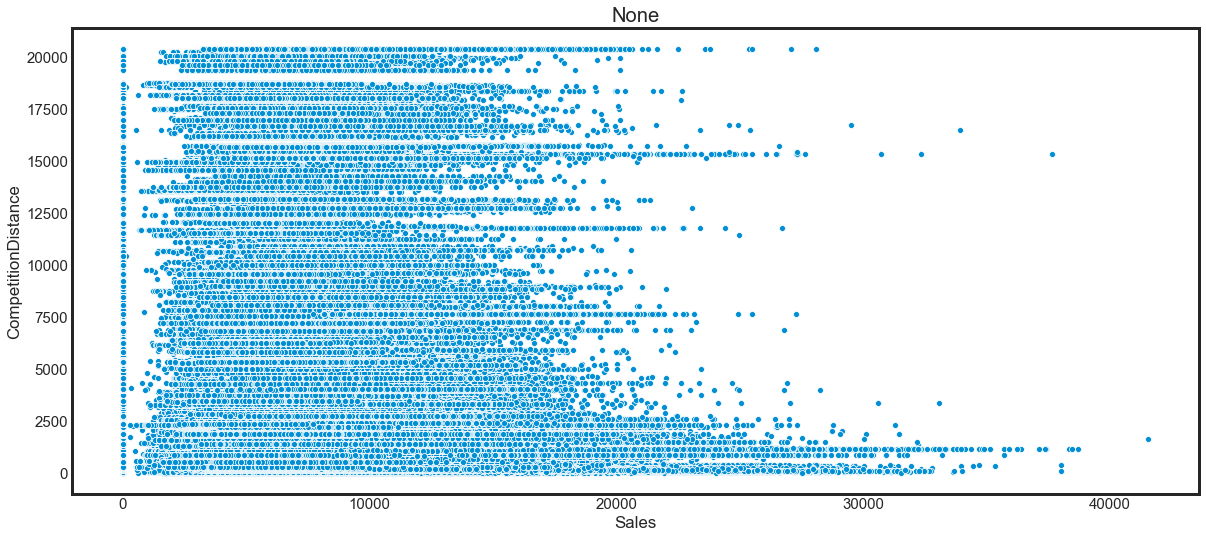

In [146]:
plot_scatter(x_axis='Sales', y_axis='CompetitionDistance')

In [41]:
train_store_df.groupby('StoreType')[['CompetitionDistance', 'Sales']].mean()

,CompetitionDistance,Sales
StoreType,,
a,3490.789483,5738.179710
b,1066.058117,10058.837334
c,2614.951330,5723.629246
d,5904.570934,5641.819243


From the result of the groupby, it showed that the distance to next competitor affect sales in a way that **the lower the distance the higher the Sales** that would be in the store.

Based on the result above, Stores may be located in the same city centres and the Distance does matter. **If the distance is much, then less sales would be made and vice versa..**

## Recommendation
**1. Provide promo in areas where competition distance is less**

**2. Product in terms of assortment should be distributed to all 4 store types. This will allow average sales per store to increase and products will be available to all type of customers**



>>>

> **How does the opening or reopening of new competitors affect stores?**

In [48]:
train_store_df['CompetitionOpenSinceYear'].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
       2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961., 1995.,
       2001., 1990., 1994., 1900., 1998.])

In [49]:
train_store_df[['StoreType', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Sales']].sample(4)

,StoreType,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Sales
99664,a,4.0,2013.0,4230
349251,a,8.0,2010.0,18282
800297,d,12.0,2014.0,6889
993499,d,5.0,2009.0,13247


In [53]:
train_store_df.groupby('CompetitionOpenSinceYear')[['Sales']].mean()\
                .reset_index().sort_values('Sales', ascending=False)

,CompetitionOpenSinceYear,Sales
0,1900.0,6889.460422
7,2000.0,6515.340082
20,2013.0,6483.684287
1,1961.0,6460.928875
4,1995.0,6160.058824
5,1998.0,6091.211253
3,1994.0,5987.539809
21,2014.0,5975.858501
16,2009.0,5933.889060
2,1990.0,5915.546921


In [57]:
# Save data into a csv
def save_to_csv(data, filename):
    print(f'Saving {filename} to CSV......')
    data.to_csv(f'{filename}_extended.csv', index=False)
    return f'Done......\n Ready for Model Building'

In [58]:
save_to_csv(train_store_df, 'train_data_ext')

Saving train_data_ext to CSV......


'Done......\n Ready for Model Building'

In [59]:
save_to_csv(test_store_df, 'test_data_ext')

Saving test_data_ext to CSV......


'Done......\n Ready for Model Building'